# 🎯 Jupiter Store - Personalized Reward Recommendation System (EDA Phase)

## Overview
This notebook performs comprehensive exploratory data analysis (EDA) on Jupiter Store's transaction data to build a personalized reward recommendation system. The analysis focuses on:


1. **Merchant Analysis**:
   - Popularity scoring system
   - Merchant segmentation
   - Transaction patterns

2. **User Segmentation**:
   - Behavioral clustering
   - Category preferences
   - Temporal patterns

## Data Source
- `Rewards.csv`: Contains detailed transaction records including:
  - User information
  - Transaction details (amount, status, timestamp)
  - Bank and merchant information
  - Category classifications
  - Rewards given to users


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Configure plotting - using modern matplotlib styles
plt.style.use('default')  # Use default style instead of deprecated 'seaborn'
sns.set_palette("husl")   # Set seaborn color palette
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")
print("📊 Ready for EDA analysis")


✅ Libraries imported successfully!
📊 Ready for EDA analysis


## 📊 Data Loading and Initial Preprocessing

### Data Loading Steps
1. Load the transactions data
2. Convert data types (timestamps, numeric values)
3. Handle missing values
4. Add derived features for analysis

### Data Cleaning Approach
- **Merchant Names**: Standardize merchant names by removing common suffixes
- **Transaction Status**: Filter for successful transactions
- **Timestamps**: Extract temporal features (hour, day, month)
- **Categories**: Clean and standardize category names


In [2]:
# Load and preprocess transaction data
print("📊 Loading and preprocessing transaction data...")
print("=" * 50)

# Load the data
df = pd.read_csv('Rewards.csv')

# Clean column names (remove trailing whitespace)
df.columns = df.columns.str.strip()

# Initial data info
print("\n🔍 Initial Data Overview:")
print(f"• Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"• Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few column names for verification
print(f"\n📋 Column names (first 10): {list(df.columns[:10])}")

# Convert data types
print("\n🔧 Converting data types...")
# Handle the datetime column - check for correct column name
datetime_col = None
for col in df.columns:
    if 'datetime' in col.lower():
        datetime_col = col
        break

if datetime_col:
    print(f"   • Found datetime column: '{datetime_col}'")
    df['transactiondatetime'] = pd.to_datetime(df[datetime_col])
else:
    print("   ⚠️  Warning: No datetime column found, using index")
    df['transactiondatetime'] = pd.Timestamp.now()

# Handle transaction amount column
amount_col = None
for col in df.columns:
    if 'amount' in col.lower():
        amount_col = col
        break

if amount_col:
    print(f"   • Found amount column: '{amount_col}'")
    df['transactionamount'] = pd.to_numeric(df[amount_col], errors='coerce')
else:
    print("   ⚠️  Warning: No amount column found")

# Add temporal features
print("\n⏰ Adding temporal features...")
df['hour'] = df['transactiondatetime'].dt.hour
df['day_of_week'] = df['transactiondatetime'].dt.day_name()
df['day_of_month'] = df['transactiondatetime'].dt.day
df['month'] = df['transactiondatetime'].dt.month_name()
df['is_weekend'] = df['transactiondatetime'].dt.dayofweek >= 5

# Use original merchant names without aggressive cleaning
print("\n🏪 Using original merchant names from data...")
def clean_merchant_name(name):
    """Basic cleaning - only handle nulls and strip whitespace"""
    if pd.isna(name) or str(name).strip() == '':
        return 'Unknown'
    return str(name).strip()

# Find merchant-related columns
payee_col = None
merchant_col = None
for col in df.columns:
    if 'payee' in col.lower():
        payee_col = col
    elif 'merchant' in col.lower():
        merchant_col = col

# Create unified merchant field with flexible column matching
if payee_col and merchant_col:
    print(f"   • Found merchant columns: '{payee_col}' and '{merchant_col}'")
    df['merchant_name'] = df[payee_col].fillna(df[merchant_col]).fillna('Unknown')
elif payee_col:
    print(f"   • Found payee column: '{payee_col}'")
    df['merchant_name'] = df[payee_col].fillna('Unknown')
elif merchant_col:
    print(f"   • Found merchant column: '{merchant_col}'")
    df['merchant_name'] = df[merchant_col].fillna('Unknown')
else:
    print("   ⚠️  Warning: No merchant columns found, using 'Unknown'")
    df['merchant_name'] = 'Unknown'

df['merchant_clean'] = df['merchant_name'].apply(clean_merchant_name)

print(f"   ✅ Merchant processing complete!")
print(f"   • Total unique merchants found: {df['merchant_clean'].nunique():,}")
print(f"   • Sample merchants: {list(df['merchant_clean'].value_counts().head().index)}")

# Filter for successful transactions with flexible column matching
print("\n✅ Filtering for successful transactions...")

# Find status-related columns
status_col = None
debit_col = None
for col in df.columns:
    if 'status' in col.lower():
        status_col = col
    elif 'debit' in col.lower() or 'credit' in col.lower():
        debit_col = col

# Apply filters based on available columns
filter_conditions = []

if status_col and 'SUCCESS' in df[status_col].unique():
    filter_conditions.append(df[status_col] == 'SUCCESS')
    print(f"   • Filtering by status column: '{status_col}'")

if debit_col and 'DEBIT' in df[debit_col].unique():
    filter_conditions.append(df[debit_col] == 'DEBIT')
    print(f"   • Filtering by debit column: '{debit_col}'")

if 'transactionamount' in df.columns:
    filter_conditions.append(df['transactionamount'] > 0)
    print(f"   • Filtering by positive transaction amounts")

# Apply all available filters
if filter_conditions:
    df_clean = df[pd.concat(filter_conditions, axis=1).all(axis=1)].copy()
else:
    print("   ⚠️  Warning: No filter conditions found, using all data")
    df_clean = df.copy()

# Print cleaning results
reduction = ((len(df) - len(df_clean)) / len(df) * 100)
print(f"\n📈 Cleaning Results:")
print(f"• Original transactions: {len(df):,}")
print(f"• Clean transactions: {len(df_clean):,}")
print(f"• Reduction: {reduction:.1f}%")

# Update main dataframe
df = df_clean.copy()

# Create standardized column references for analysis
print("\n🔧 Creating standardized column mappings...")

# Find and standardize key columns
bank_col = None
user_col = None
category_col = None

for col in df.columns:
    if 'bank' in col.lower():
        bank_col = col
    elif 'user' in col.lower() and 'id' in col.lower():
        user_col = col
    elif 'coarse' in col.lower() and 'category' in col.lower():
        category_col = col

# Create standardized references
if bank_col:
    df['bankname'] = df[bank_col]
    print(f"   • Bank column mapped: '{bank_col}' -> 'bankname'")

if user_col:
    df['user_id'] = df[user_col]
    print(f"   • User column mapped: '{user_col}' -> 'user_id'")

if category_col:
    df['jupiter_coarsegrain_category'] = df[category_col]
    print(f"   • Category column mapped: '{category_col}' -> 'jupiter_coarsegrain_category'")

# Display sample of cleaned data
print("\n📋 Sample of Cleaned Data:")
sample_cols = ['transactiondatetime', 'merchant_clean']

if 'bankname' in df.columns:
    sample_cols.append('bankname')
if 'transactionamount' in df.columns:
    sample_cols.append('transactionamount')
if 'jupiter_coarsegrain_category' in df.columns:
    sample_cols.append('jupiter_coarsegrain_category')

display(df[sample_cols].head())


📊 Loading and preprocessing transaction data...

🔍 Initial Data Overview:
• Shape: 7,968 rows × 71 columns
• Memory usage: 25.20 MB

📋 Column names (first 10): ['flag', 'num', 'mmuuid', 'user_id', 'transactiondatetime', 'transactionstatus', 'jupiterfinegraincategory', 'jupiter_coarsegrain_category', 'usercategory', 'appcategory']

🔧 Converting data types...
   • Found datetime column: 'transactiondatetime'
   • Found amount column: 'transactionamount'

⏰ Adding temporal features...

🏪 Using original merchant names from data...
   • Found merchant columns: 'payeeparticulars' and 'merchant'
   ✅ Merchant processing complete!
   • Total unique merchants found: 6,290
   • Sample merchants: ['{"name":"Zomato Ltd","entityType":"ENTITY","upiNumber":"","vpa":"zomato-order@ptybl","mccCode":"5812"}', '{"name":"Zomato private Limited","entityType":"ENTITY","upiNumber":"","vpa":"zomato.payu@axisbank","mccCode":"5812"}', '{"name":"ZOMATO","entityType":"ENTITY","upiNumber":"","vpa":"payzomato@hdfcba

,transactiondatetime,merchant_clean,bankname,transactionamount,jupiter_coarsegrain_category
0,2026-07-15 23:04:28+00:00,"{""mccCode"":""5541"",""merchantID"":""47000009533081...",Federal_Bank,110.00,transport
1,2026-07-15 21:18:29+00:00,"{""mccCode"":""4900"",""merchantID"":""39PU0000000363...",Federal_Bank,201.00,finance
2,2026-01-01 00:23:58+00:00,"{""mccCode"":""5812"",""merchantID"":""_RAJINDER 2 O....",Federal_Bank,1964.00,food & drinks
3,2026-01-01 00:27:20+00:00,"{""mccCode"":""4814"",""merchantID"":""89050458"",""mer...",Federal_Bank,994.00,bills & utilities
4,2026-01-01 00:11:00+00:00,"{""mccCode"":""4900"",""merchantID"":""ACCL8ADDCYBS"",...",Federal_Bank,997.00,bills & utilities


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7968 entries, 0 to 7967
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   flag                             7968 non-null   object             
 1   num                              7968 non-null   int64              
 2   mmuuid                           7968 non-null   object             
 3   user_id                          7968 non-null   object             
 4   transactiondatetime              7968 non-null   datetime64[ns, UTC]
 5   transactionstatus                7968 non-null   object             
 6   jupiterfinegraincategory         7968 non-null   object             
 7   jupiter_coarsegrain_category     7968 non-null   object             
 8   usercategory                     7968 non-null   object             
 9   appcategory                      7968 non-null   object             
 10  

In [14]:
distinct_user_count = df['user_id'].nunique()
print(f" Distinct user_id count: {distinct_user_count}")

 Distinct user_id count: 7278


## 📱 Transaction Channel & Type Analysis

### Analysis Goals
Understanding bank transaction patterns helps in:
1. **Pattern Detection**: Identify unusual transaction timing patterns
2. **Service Optimization**: Understand peak transaction hours by bank
3. **Risk Management**: Detect outliers in transaction timing

### Visualization Approach
We'll create two focused visualizations:
1. **24-Hour Transaction Distribution**: Shows when different banks are most active
2. **Transaction Success Rate Heatmap**: Reveals reliability patterns by bank and hour


📱 Transaction Channel & Type Analysis

📊 Step 1: Transaction Channel Distribution Analysis
   • Total unique channels: 6
   • Available channels: ['UPI', 'BLAZE_UPI', 'BLAZE_CARD', 'DEBIT_CARD', 'EDGE_CARD', 'BANK-TRANSFER']

🔥 Top Transaction Channels:
   1. UPI: 3,541.0 transactions (44.4%)
   2. BLAZE_UPI: 3,050.0 transactions (38.3%)
   3. BLAZE_CARD: 786.0 transactions (9.9%)
   4. DEBIT_CARD: 358.0 transactions (4.5%)
   5. EDGE_CARD: 227.0 transactions (2.9%)


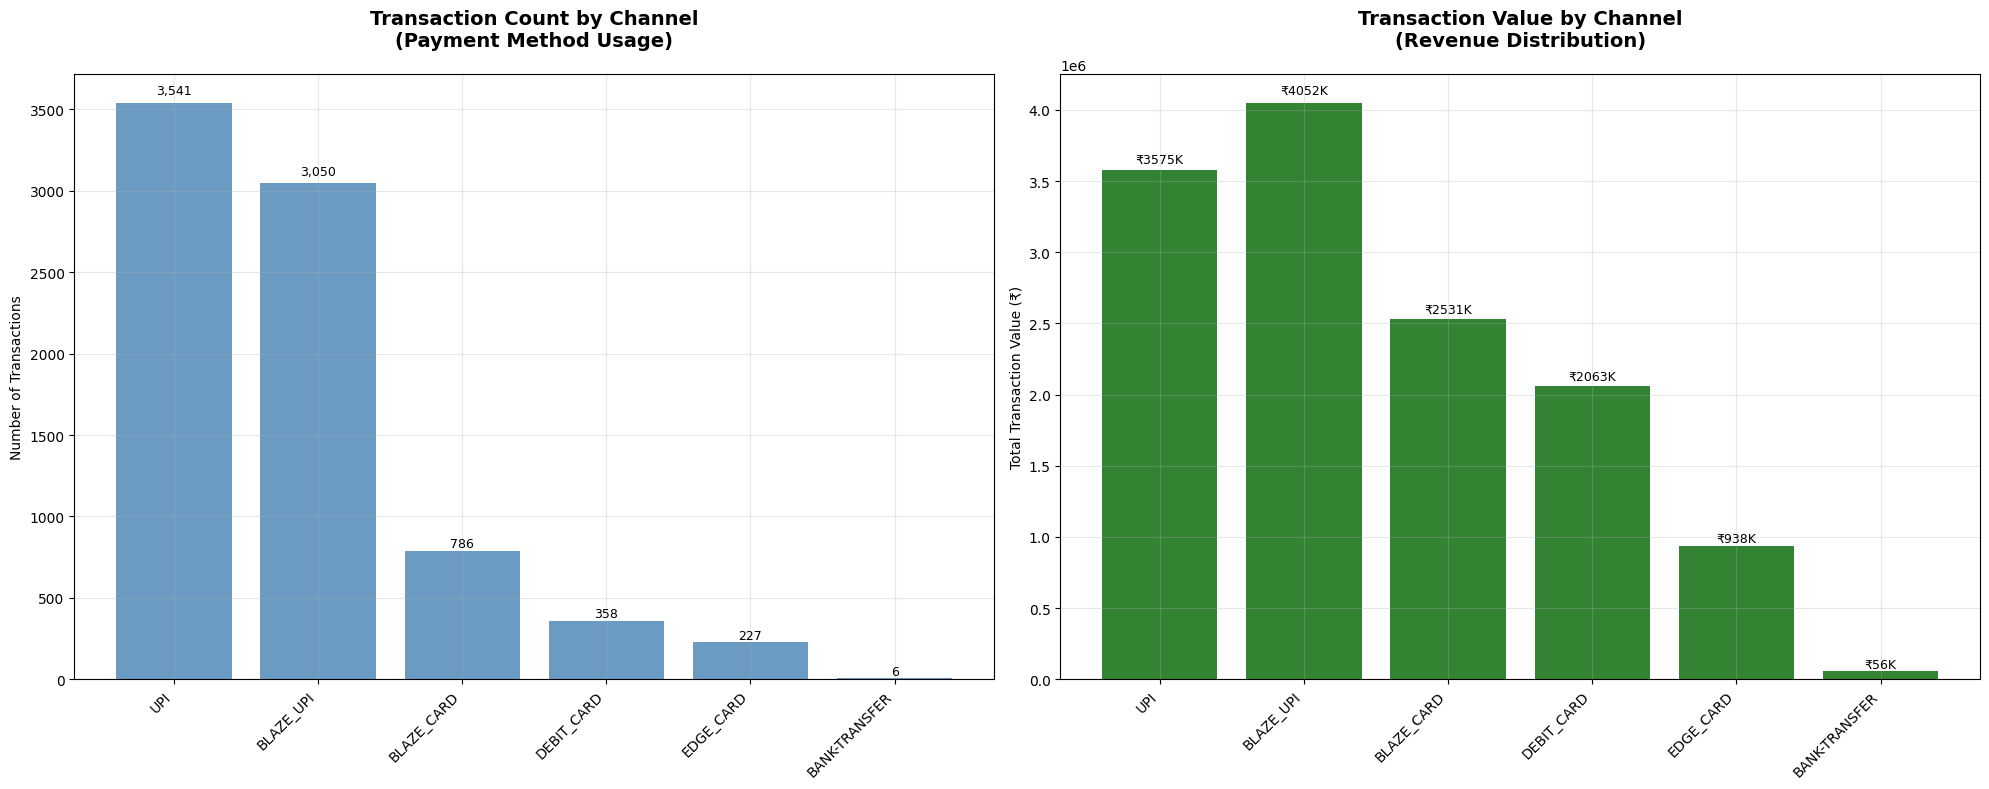


📊 Step 2: Transaction Type Distribution Analysis
   • Total unique types: 11
   • Available types: ['PAY', 'DEBIT', 'ONLINE', 'POS_DIP', 'ECOM', 'COLLECT_RECEIVED', 'POS_TAP', 'CONTACTLESS_POS', 'POS', 'JUPITER.TRANSFERS.MODES.IFT', 'SELF_PAY']

🛒 Top Transaction Types:
   1. PAY: 3,385.0 transactions (42.5%)
   2. DEBIT: 3,050.0 transactions (38.3%)
   3. ONLINE: 551.0 transactions (6.9%)
   4. POS_DIP: 329.0 transactions (4.1%)
   5. ECOM: 260.0 transactions (3.3%)

📋 Detailed Transaction Type Analysis:


,txn_count,total_value,avg_amount,unique_users,market_share
transactiontype,,,,,
PAY,3385,"₹3,434,056",₹1014,3040,42.48
DEBIT,3050,"₹4,051,649",₹1328,2821,38.28
ONLINE,551,"₹1,993,165",₹3617,525,6.92
POS_DIP,329,"₹1,172,759",₹3565,314,4.13
ECOM,260,"₹1,899,238",₹7305,246,3.26
COLLECT_RECEIVED,155,"₹139,710",₹901,151,1.95
POS_TAP,133,"₹302,857",₹2277,128,1.67
CONTACTLESS_POS,52,"₹45,649",₹878,51,0.65
POS,46,"₹117,814",₹2561,43,0.58



📊 Step 3: Channel-Type Cross Analysis
   🔥 Top Channel-Type Combinations:
   • UPI + PAY: 3,385 (42.5%)
   • BLAZE_UPI + DEBIT: 3,050 (38.3%)
   • BLAZE_CARD + ONLINE: 395 (5.0%)
   • BLAZE_CARD + POS_DIP: 275 (3.5%)
   • DEBIT_CARD + ECOM: 260 (3.3%)
   • EDGE_CARD + ONLINE: 156 (2.0%)
   • UPI + COLLECT_RECEIVED: 155 (1.9%)
   • BLAZE_CARD + POS_TAP: 116 (1.5%)
   • EDGE_CARD + POS_DIP: 54 (0.7%)
   • DEBIT_CARD + CONTACTLESS_POS: 52 (0.7%)


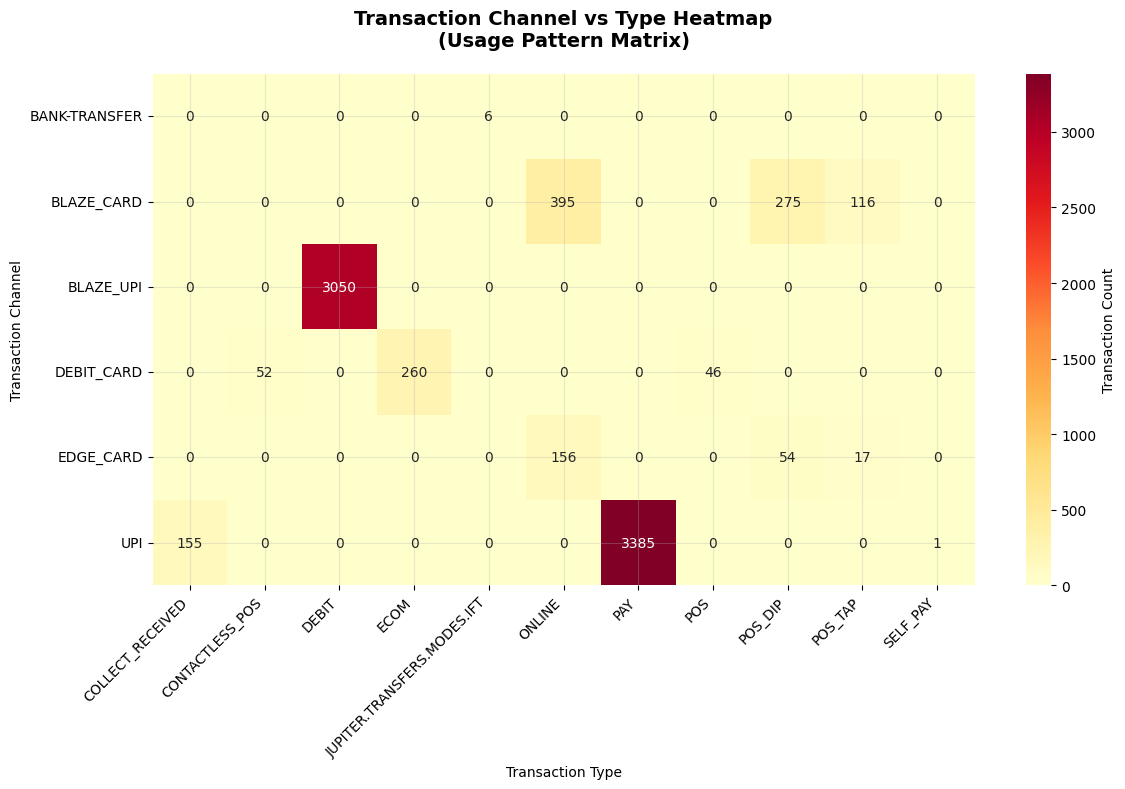

In [3]:
# Comprehensive Transaction Channel & Type Analysis
print("📱 Transaction Channel & Type Analysis")
print("=" * 60)

# Step 1: Analyze Transaction Channels
print("\n📊 Step 1: Transaction Channel Distribution Analysis")
print("=" * 50)

# Analyze transactionchannel column
if 'transactionchannel' in df.columns:
    channel_stats = df['transactionchannel'].value_counts()
    print(f"   • Total unique channels: {len(channel_stats)}")
    print(f"   • Available channels: {list(channel_stats.index)}")
    
    # Calculate channel statistics
    channel_analysis = df.groupby('transactionchannel').agg({
        'transactionamount': ['count', 'sum', 'mean'],
        'user_id': 'nunique'
    }).round(2)
    channel_analysis.columns = ['txn_count', 'total_value', 'avg_amount', 'unique_users']
    channel_analysis['market_share'] = (channel_analysis['txn_count'] / len(df) * 100).round(2)
    channel_analysis = channel_analysis.sort_values('txn_count', ascending=False)
    
    print(f"\n🔥 Top Transaction Channels:")
    for idx, (channel, stats) in enumerate(channel_analysis.head().iterrows(), 1):
        print(f"   {idx}. {channel}: {stats['txn_count']:,} transactions ({stats['market_share']:.1f}%)")
        
    # Create visualization for channels
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Channel Distribution
    top_channels = channel_analysis.head(8)
    bars1 = axes[0].bar(range(len(top_channels)), top_channels['txn_count'], 
                       color='steelblue', alpha=0.8)
    axes[0].set_xticks(range(len(top_channels)))
    axes[0].set_xticklabels(top_channels.index, rotation=45, ha='right')
    axes[0].set_ylabel('Number of Transactions')
    axes[0].set_title('Transaction Count by Channel\n(Payment Method Usage)', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + height*0.01, 
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Channel Value Distribution
    bars2 = axes[1].bar(range(len(top_channels)), top_channels['total_value'], 
                       color='darkgreen', alpha=0.8)
    axes[1].set_xticks(range(len(top_channels)))
    axes[1].set_xticklabels(top_channels.index, rotation=45, ha='right')
    axes[1].set_ylabel('Total Transaction Value (₹)')
    axes[1].set_title('Transaction Value by Channel\n(Revenue Distribution)', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + height*0.01, 
                    f'₹{height/1000:.0f}K', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("   ❌ No transactionchannel column found!")

# Step 2: Analyze Transaction Types
print(f"\n📊 Step 2: Transaction Type Distribution Analysis")
print("=" * 50)

if 'transactiontype' in df.columns:
    type_stats = df['transactiontype'].value_counts()
    print(f"   • Total unique types: {len(type_stats)}")
    print(f"   • Available types: {list(type_stats.index)}")
    
    # Calculate type statistics
    type_analysis = df.groupby('transactiontype').agg({
        'transactionamount': ['count', 'sum', 'mean'],
        'user_id': 'nunique'
    }).round(2)
    type_analysis.columns = ['txn_count', 'total_value', 'avg_amount', 'unique_users']
    type_analysis['market_share'] = (type_analysis['txn_count'] / len(df) * 100).round(2)
    type_analysis = type_analysis.sort_values('txn_count', ascending=False)
    
    print(f"\n🛒 Top Transaction Types:")
    for idx, (tx_type, stats) in enumerate(type_analysis.head().iterrows(), 1):
        print(f"   {idx}. {tx_type}: {stats['txn_count']:,} transactions ({stats['market_share']:.1f}%)")
        
    # Display detailed breakdown
    print(f"\n📋 Detailed Transaction Type Analysis:")
    type_display = type_analysis.head(10).copy()
    type_display['total_value'] = type_display['total_value'].apply(lambda x: f"₹{x:,.0f}")
    type_display['avg_amount'] = type_display['avg_amount'].apply(lambda x: f"₹{x:.0f}")
    display(type_display)
else:
    print("   ❌ No transactiontype column found!")

# Step 3: Cross-Analysis of Channel + Type
print(f"\n📊 Step 3: Channel-Type Cross Analysis")
print("=" * 50)

if 'transactionchannel' in df.columns and 'transactiontype' in df.columns:
    cross_analysis = df.groupby(['transactionchannel', 'transactiontype']).size().reset_index(name='count')
    cross_analysis['percentage'] = (cross_analysis['count'] / len(df) * 100).round(2)
    cross_analysis = cross_analysis.sort_values('count', ascending=False).head(15)
    
    print("   🔥 Top Channel-Type Combinations:")
    for idx, row in cross_analysis.head(10).iterrows():
        print(f"   • {row['transactionchannel']} + {row['transactiontype']}: {row['count']:,} ({row['percentage']:.1f}%)")
        
    # Create a pivot table for heatmap
    pivot_data = df.groupby(['transactionchannel', 'transactiontype']).size().unstack(fill_value=0)
    
    # Plot heatmap if data exists
    if not pivot_data.empty:
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_data, annot=True, fmt='d', cmap='YlOrRd', 
                   cbar_kws={'label': 'Transaction Count'})
        plt.title('Transaction Channel vs Type Heatmap\n(Usage Pattern Matrix)', 
                 fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Transaction Type')
        plt.ylabel('Transaction Channel')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
else:
    print("   ❌ Cannot perform cross-analysis - missing columns")


## 🏪 Enhanced Merchant Analysis & Intelligent Categorization

### 📊 Advanced Merchant Popularity Scoring

Our **Enhanced Popularity Score** uses a sophisticated multi-factor algorithm that considers:

1. **Transaction Volume (40%)**: Raw number of transactions indicating merchant usage frequency
2. **User Reach (30%)**: Unique user count showing market penetration and appeal  
3. **Transaction Consistency (30%)**: Daily transaction rate indicating sustained business activity

**Scoring Formula**: `Popularity Score = 0.4 × Volume_Rank + 0.3 × User_Rank + 0.3 × Consistency_Rank`

Where each component is normalized to percentile rankings (0-1 scale) to ensure balanced weighting and prevent any single metric from dominating the score.

### 🏷️ Intelligent Merchant Categorization

We implement **automated merchant categorization** using pattern matching and keyword analysis to group similar businesses:

#### **Category Definitions:**
- **🍔 Food & Dining**: Restaurants, food delivery, cafes (Swiggy, Zomato, McDonald's, Starbucks)
- **🛒 E-Commerce & Retail**: Online shopping, marketplaces (Amazon, Flipkart, retail stores)
- **⛽ Fuel & Transportation**: Gas stations, transport services (petrol pumps, Uber, Ola)
- **💳 Financial Services**: Banks, payment services, fintech (PayTM, PhonePe, banking services)
- **🎬 Entertainment & Media**: Streaming, gaming, entertainment (Netflix, gaming platforms)
- **🏥 Healthcare & Wellness**: Medical services, pharmacies, fitness (hospitals, clinics, gyms)
- **🛍️ Shopping & Fashion**: Clothing, accessories, lifestyle (fashion brands, lifestyle stores)
- **🏠 Utilities & Services**: Bill payments, utilities, professional services
- **🎓 Education & Learning**: Educational institutions, online courses, books
- **✈️ Travel & Hospitality**: Hotels, travel booking, tourism services
- **📱 Technology & Electronics**: Tech products, gadgets, software services
- **🌟 Others**: Miscellaneous merchants not fitting above categories

This categorization enables **behavioral segmentation** and **targeted recommendation strategies** for different merchant types and user preferences.


📱 Transaction Channel & Type Analysis

📊 Step 1: Ranking Top 30 Banks by Transaction Volume
📈 Total Banks: 2
🏆 Top 30 Banks Analysis:
   • Combined Transactions: 7,774 (100.0% of total)
   • Combined Value: ₹12,369,734 (100.0% of total)
   • Average transactions per bank: 3887

🏅 TOP 15 BANKS DETAILED RANKING:


,txn_count,total_value,unique_users,user_penetration,avg_amount,txn_per_day
bankname,,,,,,
Yes_Bank,7419,10317549.45,6763,92.92,1390.69,105.99
Federal_Bank,355,2052184.81,336,4.62,5780.80,0.85



📊 Step 2: Creating Comprehensive Bank Visualizations


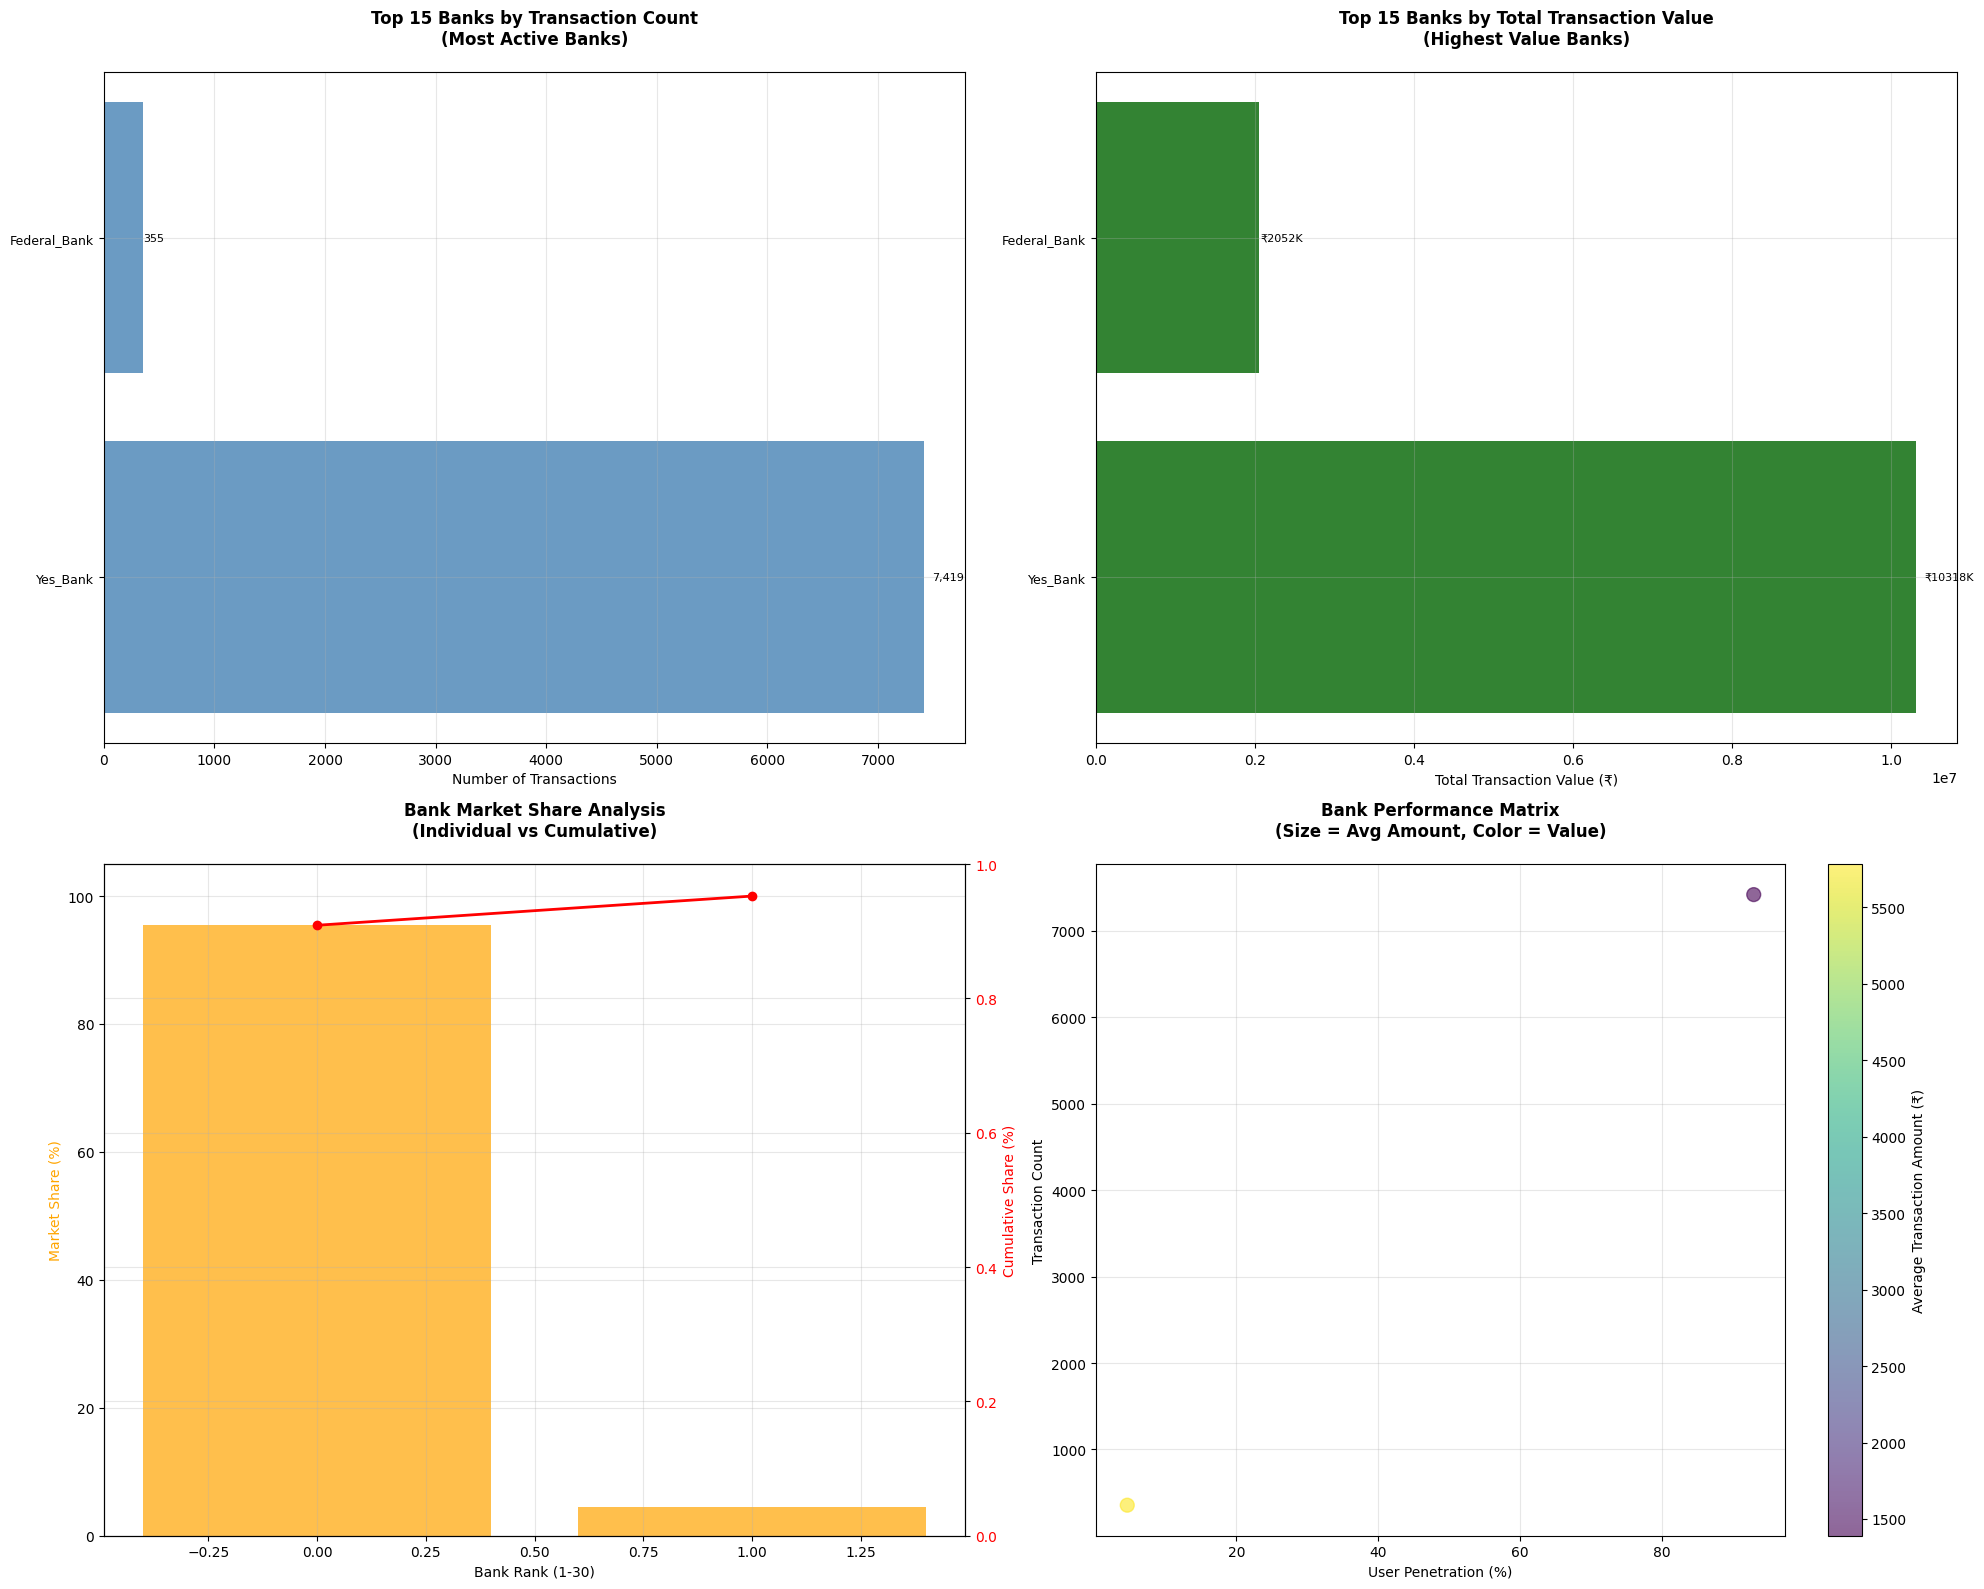


⏰ Step 3: Temporal Analysis - Transactions vs Time


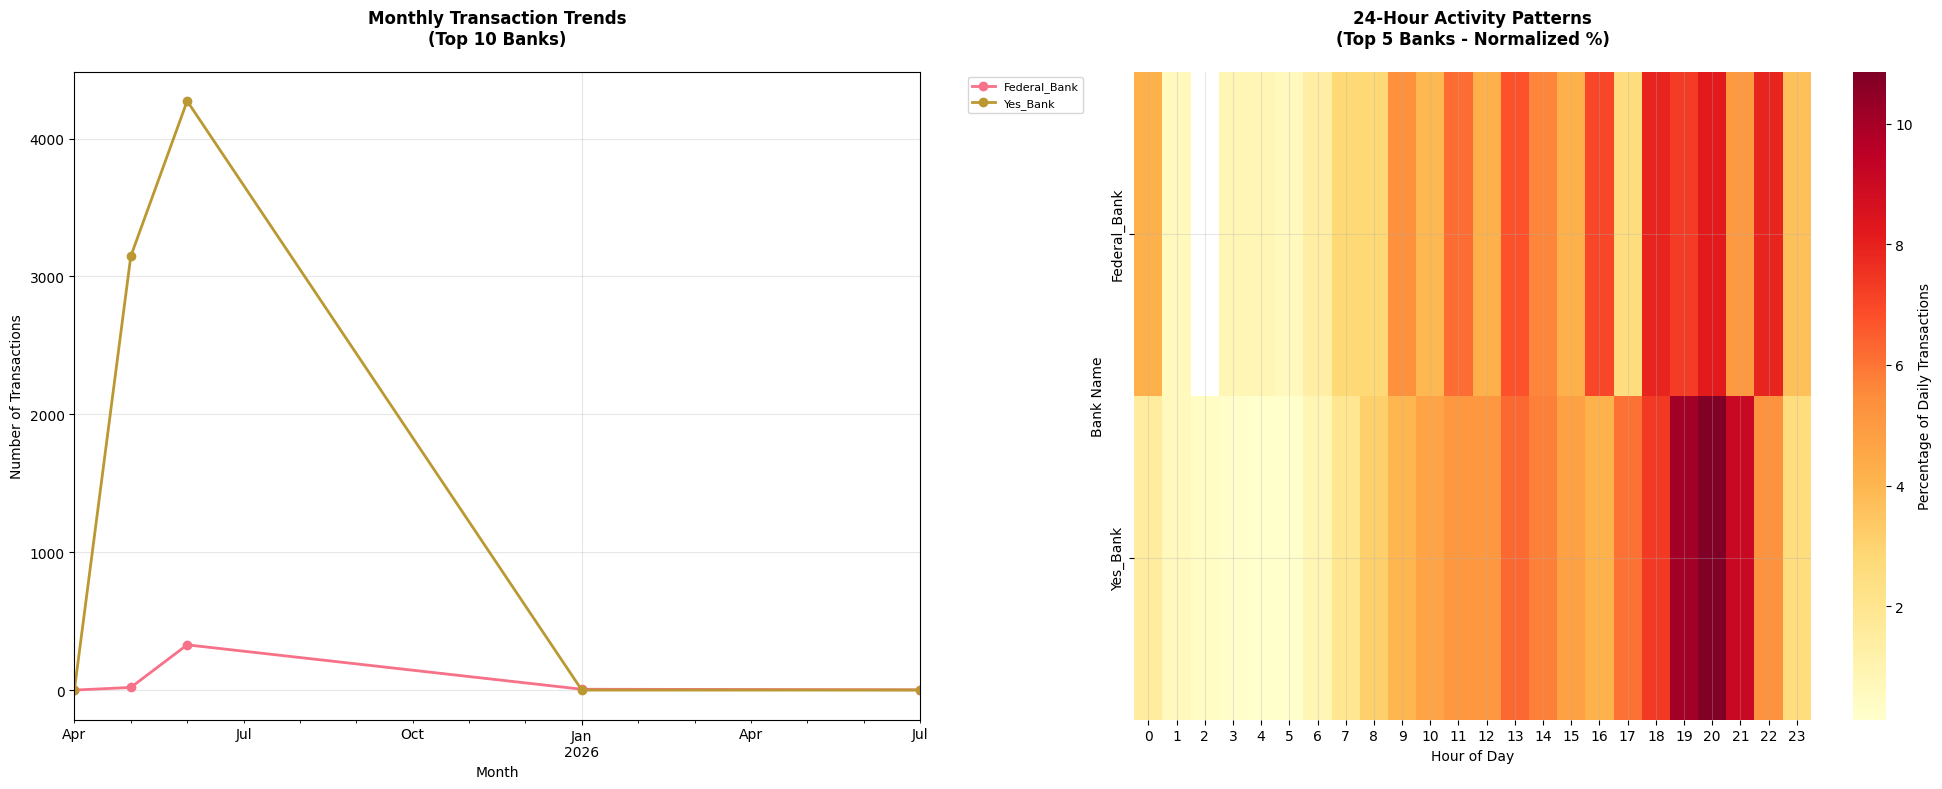


🔍 Key Insights from Bank Analysis:
📊 Market Concentration:
   • Top 5 banks control: 100.0% of transactions
   • Top 10 banks control: 100.0% of transactions
   • Top 30 banks control: 100.0% of transactions

🏆 Performance Leaders:
   • Highest Volume: Yes_Bank (7,419 transactions)
   • Highest Value: Yes_Bank (₹10,317,549)
   • Highest User Penetration: Yes_Bank (92.9% of users)

⏰ Temporal Patterns (Top 5 Banks):
   • Yes_Bank: Peak at 20:00 on Thursday
   • Federal_Bank: Peak at 20:00 on Thursday


In [4]:
# Comprehensive Transaction Channel & Type Analysis
print("📱 Transaction Channel & Type Analysis")
print("=" * 60)

if df is not None and len(df) > 0:
    # Step 1: Analyze Top 30 Banks by Transaction Volume
    print("\n📊 Step 1: Ranking Top 30 Banks by Transaction Volume")
    print("=" * 50)
    
    # Calculate comprehensive bank statistics
    bank_stats = df.groupby('bankname').agg({
        'transactionamount': ['count', 'sum', 'mean', 'std'],
        'user_id': 'nunique',
        'transactiondatetime': ['min', 'max']
    }).round(2)
    
    bank_stats.columns = ['txn_count', 'total_value', 'avg_amount', 
                         'amount_std', 'unique_users', 'first_txn', 'last_txn']
    
    # Calculate additional metrics
    bank_stats['days_active'] = (bank_stats['last_txn'] - bank_stats['first_txn']).dt.days + 1
    bank_stats['txn_per_day'] = bank_stats['txn_count'] / bank_stats['days_active']
    bank_stats['user_penetration'] = (bank_stats['unique_users'] / df['user_id'].nunique() * 100).round(2)
    bank_stats['avg_txn_per_user'] = (bank_stats['txn_count'] / bank_stats['unique_users']).round(2)
    
    # Get top 30 banks
    top_30_banks = bank_stats.sort_values('txn_count', ascending=False).head(30)
    
    print(f"📈 Total Banks: {len(bank_stats):,}")
    print(f"🏆 Top 30 Banks Analysis:")
    print(f"   • Combined Transactions: {top_30_banks['txn_count'].sum():,} ({top_30_banks['txn_count'].sum()/bank_stats['txn_count'].sum()*100:.1f}% of total)")
    print(f"   • Combined Value: ₹{top_30_banks['total_value'].sum():,.0f} ({top_30_banks['total_value'].sum()/bank_stats['total_value'].sum()*100:.1f}% of total)")
    print(f"   • Average transactions per bank: {top_30_banks['txn_count'].mean():.0f}")
    
    # Display top 15 banks in detail
    print(f"\n🏅 TOP 15 BANKS DETAILED RANKING:")
    top_15_display = top_30_banks.head(15)[['txn_count', 'total_value', 'unique_users', 
                                           'user_penetration', 'avg_amount', 'txn_per_day']]
    display(top_15_display)
    
    # Step 2: Create Comprehensive Visualizations
    print("\n📊 Step 2: Creating Comprehensive Bank Visualizations")
    print("=" * 50)
    
    # Visualization 1: Top 30 Banks Transaction Volume
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Top 15 Banks by Transaction Count
    top_15_banks = top_30_banks.head(15)
    bars1 = axes[0,0].barh(range(len(top_15_banks)), top_15_banks['txn_count'], 
                          color='steelblue', alpha=0.8)
    axes[0,0].set_yticks(range(len(top_15_banks)))
    axes[0,0].set_yticklabels(top_15_banks.index, fontsize=9)
    axes[0,0].set_xlabel('Number of Transactions')
    axes[0,0].set_title('Top 15 Banks by Transaction Count\n(Most Active Banks)', 
                       fontsize=12, fontweight='bold', pad=20)
    axes[0,0].grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        width = bar.get_width()
        axes[0,0].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                      f'{int(width):,}', ha='left', va='center', fontsize=8)
    
    # Plot 2: Top 15 Banks by Total Value
    bars2 = axes[0,1].barh(range(len(top_15_banks)), top_15_banks['total_value'], 
                          color='darkgreen', alpha=0.8)
    axes[0,1].set_yticks(range(len(top_15_banks)))
    axes[0,1].set_yticklabels(top_15_banks.index, fontsize=9)
    axes[0,1].set_xlabel('Total Transaction Value (₹)')
    axes[0,1].set_title('Top 15 Banks by Total Transaction Value\n(Highest Value Banks)', 
                       fontsize=12, fontweight='bold', pad=20)
    axes[0,1].grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        width = bar.get_width()
        axes[0,1].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                      f'₹{width/1000:.0f}K', ha='left', va='center', fontsize=8)
    
    # Plot 3: Bank Market Share (Top 30)
    market_share = top_30_banks['txn_count'] / bank_stats['txn_count'].sum() * 100
    cumulative_share = market_share.cumsum()
    
    axes[1,0].bar(range(len(top_30_banks)), market_share, color='orange', alpha=0.7)
    axes[1,0].plot(range(len(top_30_banks)), cumulative_share, color='red', marker='o', linewidth=2)
    axes[1,0].set_xlabel('Bank Rank (1-30)')
    axes[1,0].set_ylabel('Market Share (%)', color='orange')
    axes[1,0].set_title('Bank Market Share Analysis\n(Individual vs Cumulative)', 
                       fontsize=12, fontweight='bold', pad=20)
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Secondary y-axis for cumulative
    ax2 = axes[1,0].twinx()
    ax2.set_ylabel('Cumulative Share (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Plot 4: User Penetration vs Transaction Volume Scatter
    scatter = axes[1,1].scatter(top_30_banks['user_penetration'], 
                               top_30_banks['txn_count'],
                               c=top_30_banks['avg_amount'],
                               s=100, alpha=0.6, cmap='viridis')
    
    axes[1,1].set_xlabel('User Penetration (%)')
    axes[1,1].set_ylabel('Transaction Count')
    axes[1,1].set_title('Bank Performance Matrix\n(Size = Avg Amount, Color = Value)', 
                       fontsize=12, fontweight='bold', pad=20)
    axes[1,1].grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=axes[1,1], label='Average Transaction Amount (₹)')
    
    plt.tight_layout()
    plt.show()
    
    # Step 3: Temporal Analysis - Transactions vs Time
    print("\n⏰ Step 3: Temporal Analysis - Transactions vs Time")
    print("=" * 50)
    
    # Get top 10 banks for temporal analysis
    top_10_banks = top_30_banks.head(10).index.tolist()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Monthly Transaction Trends for Top 10 Banks
    if df['transactiondatetime'].dt.to_period('M').nunique() > 1:
        monthly_trends = df[df['bankname'].isin(top_10_banks)].groupby([
            df['transactiondatetime'].dt.to_period('M'), 'bankname'
        ]).size().unstack(fill_value=0)
        
        monthly_trends.plot(kind='line', ax=axes[0], marker='o', linewidth=2)
        axes[0].set_title('Monthly Transaction Trends\n(Top 10 Banks)', 
                         fontsize=12, fontweight='bold', pad=20)
        axes[0].set_xlabel('Month')
        axes[0].set_ylabel('Number of Transactions')
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[0].grid(True, alpha=0.3)
    
    
    # Plot 2: 24-Hour Activity Patterns for Top 5 Banks
    top_5_banks = top_30_banks.head(5).index.tolist()
    hourly_patterns = df[df['bankname'].isin(top_5_banks)].groupby(['bankname', 'hour']).size().unstack()
    
    # Normalize to show percentage
    hourly_patterns_pct = hourly_patterns.div(hourly_patterns.sum(axis=1), axis=0) * 100
    
    sns.heatmap(hourly_patterns_pct, 
                ax=axes[1],
                cmap='YlOrRd',
                cbar_kws={'label': 'Percentage of Daily Transactions'})
    
    axes[1].set_title('24-Hour Activity Patterns\n(Top 5 Banks - Normalized %)', 
                     fontsize=12, fontweight='bold', pad=20)
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Bank Name')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed insights
    print("\n🔍 Key Insights from Bank Analysis:")
    print("=" * 50)
    
    # Market concentration
    top_5_share = top_30_banks.head(5)['txn_count'].sum() / bank_stats['txn_count'].sum() * 100
    top_10_share = top_30_banks.head(10)['txn_count'].sum() / bank_stats['txn_count'].sum() * 100
    
    print(f"📊 Market Concentration:")
    print(f"   • Top 5 banks control: {top_5_share:.1f}% of transactions")
    print(f"   • Top 10 banks control: {top_10_share:.1f}% of transactions")
    print(f"   • Top 30 banks control: {top_30_banks['txn_count'].sum()/bank_stats['txn_count'].sum()*100:.1f}% of transactions")
    
    # Performance insights
    print(f"\n🏆 Performance Leaders:")
    highest_volume_bank = top_30_banks['txn_count'].idxmax()
    highest_value_bank = top_30_banks['total_value'].idxmax()
    highest_penetration_bank = top_30_banks['user_penetration'].idxmax()
    
    print(f"   • Highest Volume: {highest_volume_bank} ({top_30_banks.loc[highest_volume_bank, 'txn_count']:,} transactions)")
    print(f"   • Highest Value: {highest_value_bank} (₹{top_30_banks.loc[highest_value_bank, 'total_value']:,.0f})")
    print(f"   • Highest User Penetration: {highest_penetration_bank} ({top_30_banks.loc[highest_penetration_bank, 'user_penetration']:.1f}% of users)")
    
    # Temporal insights for top banks
    print(f"\n⏰ Temporal Patterns (Top 5 Banks):")
    for bank in top_5_banks:
        bank_data = df[df['bankname'] == bank]
        peak_hour = bank_data.groupby('hour').size().idxmax()
        peak_day = bank_data.groupby('day_of_week').size().idxmax()
        
        print(f"   • {bank}: Peak at {peak_hour}:00 on {peak_day}")
    


## 🎯 Merchant Popularity Analysis & Scoring

### Scoring Methodology
Our merchant popularity score combines three key metrics:
1. **Transaction Volume** (40%): Total number of transactions
   - Rewards high-activity merchants
   - Indicates consistent customer engagement

2. **User Base** (30%): Number of unique users
   - Measures merchant reach
   - Prevents high scores from few power users

3. **Transaction Frequency** (30%): Transactions per day
   - Rewards consistent activity
   - Balances seasonal vs regular merchants

### Visualization Approach
1. **Top Merchants Bar Plot**: Shows highest scoring merchants
2. **Component Analysis**: Scatter plot showing relationship between scoring components


🏪 Comprehensive Merchant Analysis and Distribution

📊 Step 1: Computing Merchant Statistics and Rankings
   • Examining available merchant columns...
   • Available merchant-related columns: ['payee', 'merchant', 'payeeparticulars', 'merchant_name', 'merchant_clean']
   • Using column: 'payee'
   • Total rows for analysis: 7,968
   • Unique merchants after cleaning: 5,750
   • Top merchants: ['SWIGGY', 'Zomato Ltd', 'Swiggy', 'Zomato private Limited', 'Zomato Online Order']



🎯 Computing popularity scores...
📈 Total Merchants: 5,750
🏆 Top 30 Merchants Analysis:
   • Combined Transactions: 1,437 (18.0% of total)
   • Combined Value: ₹2,085,527
   • Average transactions per merchant: 48

🏅 TOP 15 MERCHANTS DETAILED RANKING:


,txn_count,total_value,unique_users,user_penetration,avg_amount,popularity_score
merchant_for_analysis,,,,,,
SWIGGY,97,34064.00,96,1.32,351.18,1.00
Zomato Ltd,97,34029.19,92,1.26,350.82,1.00
Swiggy,95,39775.00,95,1.31,418.68,1.00
Zomato private Limited,86,28178.47,79,1.09,327.66,1.00
Zomato Online Order,85,37946.30,82,1.13,446.43,1.00
ZOMATO,84,34121.72,77,1.06,406.21,1.00
Swiggy Ltd,74,27027.00,73,1.00,365.23,1.00
Blinkit,64,44757.00,63,0.87,699.33,0.99
Amazon India,61,101021.62,59,0.81,1656.09,0.99



📊 Step 2: Creating Main Merchant Visualizations


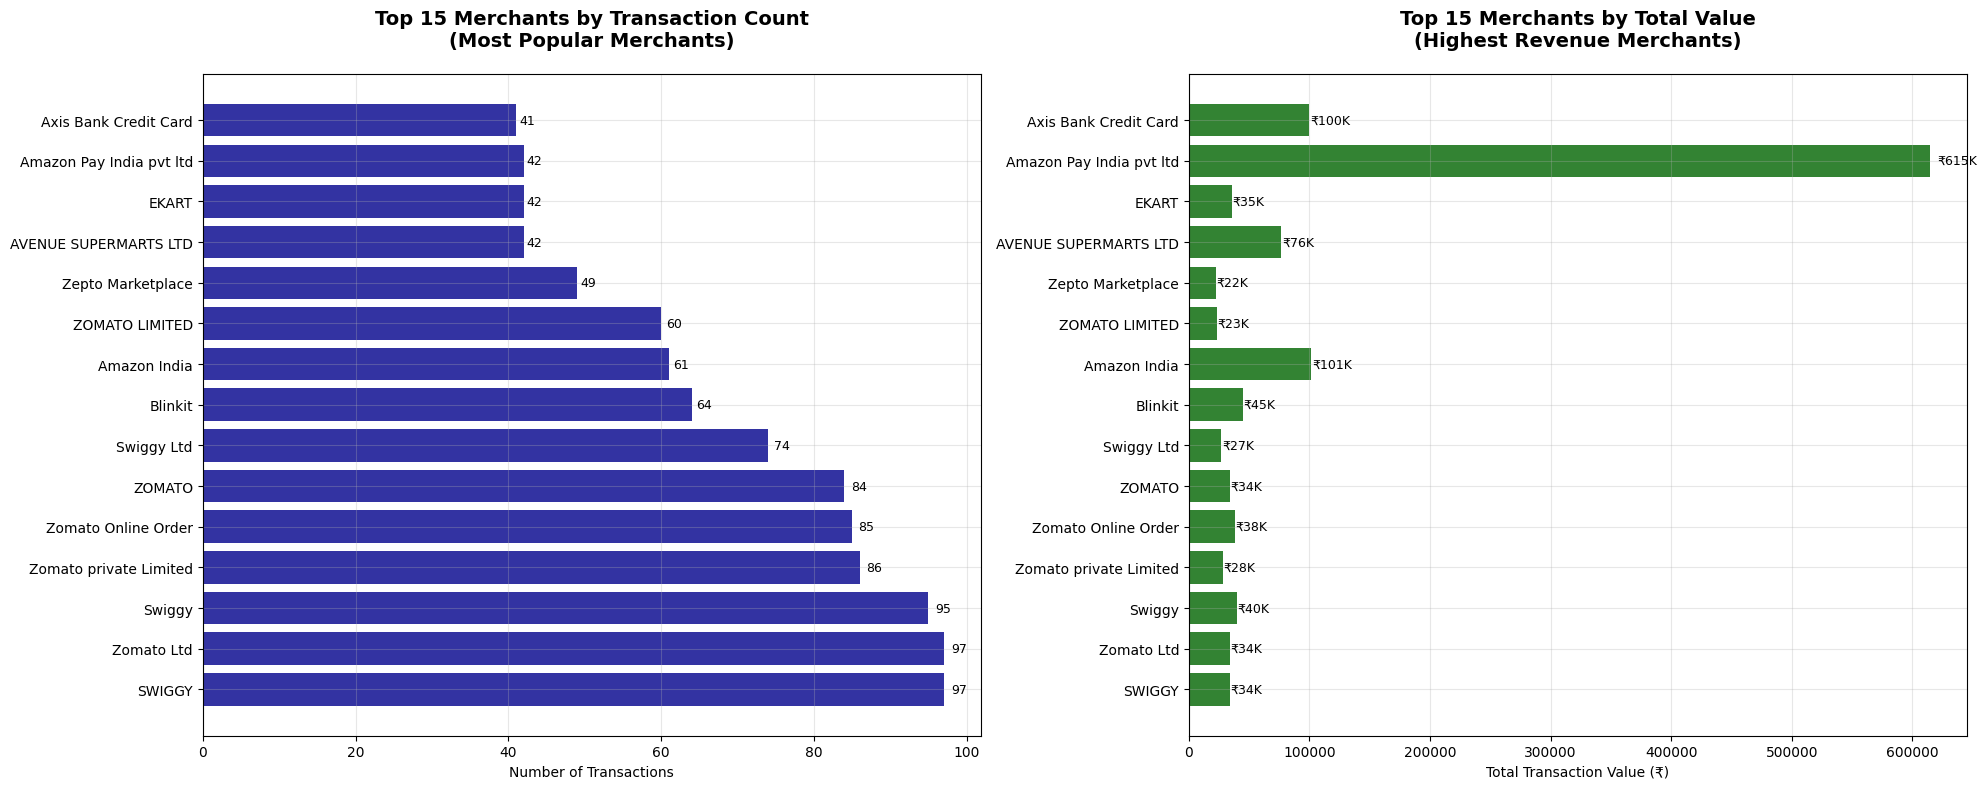


📈 Step 3: Merchant Performance Analysis
🔍 Market Concentration Analysis:
   • Top 1% merchants (57 merchants): 21.7% of transactions
   • Top 5% merchants (287 merchants): 30.3% of transactions
   • Top 10% merchants (575 merchants): 35.1% of transactions

🎯 Popularity Score Distribution:
   • Premium (Top 10%): 5,462 merchants (95.0%)
   • Elite (Top 5%): 288 merchants (5.0%)

🏆 Top Performing Merchants by Category:
   • Elite (Top 5%): SWIGGY
     Score: 0.999, Users: 96, Transactions: 97
   • Premium (Top 10%): PARACITY WINE TRADERS
     Score: 0.675, Users: 2, Transactions: 2


In [5]:
# Comprehensive Merchant Analysis and Distribution
print("🏪 Comprehensive Merchant Analysis and Distribution")
print("=" * 60)

if df is not None and len(df) > 0:
    print("\n📊 Step 1: Computing Merchant Statistics and Rankings")
    print("=" * 50)
    
    # Use original merchant data with proper cleaning for analysis
    print("   • Examining available merchant columns...")
    
    # Check both merchant and payee columns
    merchant_cols = [col for col in df.columns if 'merchant' in col.lower() or 'payee' in col.lower()]
    print(f"   • Available merchant-related columns: {merchant_cols}")
    
    # Try payee first as it often has better data
    if 'payee' in df.columns:
        merchant_data = df['payee'].copy()
        source_col = 'payee'
    elif 'merchant' in df.columns:
        merchant_data = df['merchant'].copy()
        source_col = 'merchant'
    else:
        print("   ❌ No merchant columns found!")
        merchant_stats = pd.DataFrame()  # Create empty dataframe to prevent errors
    
    print(f"   • Using column: '{source_col}'")
    
    # Clean the merchant data properly
    def clean_merchant_for_analysis(name):
        if pd.isna(name):
            return 'Unknown'
        name_str = str(name).strip()
        
        # Skip if empty or just whitespace
        if not name_str or len(name_str) == 0:
            return 'Unknown'
        
        # Skip if it's just a number (likely ID not merchant name)
        if name_str.isdigit():
            return 'Unknown'
        
        # Skip if it's mostly spaces
        if len(name_str.replace(' ', '')) < 3:
            return 'Unknown'
        
        # Keep original but trim excessive whitespace
        cleaned = ' '.join(name_str.split())
        return cleaned if len(cleaned) > 2 else 'Unknown'
    
    df['merchant_for_analysis'] = merchant_data.apply(clean_merchant_for_analysis)
    
    # Remove 'Unknown' entries for better analysis
    analysis_df = df[df['merchant_for_analysis'] != 'Unknown'].copy()
    
    print(f"   • Total rows for analysis: {len(analysis_df):,}")
    print(f"   • Unique merchants after cleaning: {analysis_df['merchant_for_analysis'].nunique():,}")
    
    # Show sample merchants
    sample_merchants = analysis_df['merchant_for_analysis'].value_counts().head().index.tolist()
    print(f"   • Top merchants: {sample_merchants[:5]}")
    
    # Calculate merchant statistics using cleaned data
    if len(analysis_df) > 0:
        merchant_stats = analysis_df.groupby('merchant_for_analysis').agg({
            'transactionamount': ['count', 'sum', 'mean', 'std'],
            'user_id': 'nunique',
            'transactiondatetime': ['min', 'max']
        }).round(2)
        
        # Update the main dataframe for consistency
        df = analysis_df.copy()
    else:
        print("   ❌ No valid merchant data after cleaning!")
        merchant_stats = pd.DataFrame()
    
    merchant_stats.columns = ['txn_count', 'total_value', 'avg_amount', 
                            'amount_std', 'unique_users', 'first_txn', 'last_txn']
    
    # Calculate additional metrics
    merchant_stats['days_active'] = (merchant_stats['last_txn'] - merchant_stats['first_txn']).dt.days + 1
    merchant_stats['txn_per_day'] = merchant_stats['txn_count'] / merchant_stats['days_active']
    merchant_stats['user_penetration'] = (merchant_stats['unique_users'] / df['user_id'].nunique() * 100).round(2)
    
    # Calculate popularity score
    print("\n🎯 Computing popularity scores...")
    merchant_stats['popularity_score'] = (
        0.4 * merchant_stats['txn_count'].rank(pct=True) +      # Transaction volume weight
        0.3 * merchant_stats['unique_users'].rank(pct=True) +   # User base weight
        0.3 * merchant_stats['txn_per_day'].rank(pct=True)      # Activity frequency weight
    )
    
    # Get top merchants
    top_30_merchants = merchant_stats.sort_values('txn_count', ascending=False).head(30)
    
    print(f"📈 Total Merchants: {len(merchant_stats):,}")
    print(f"🏆 Top 30 Merchants Analysis:")
    print(f"   • Combined Transactions: {top_30_merchants['txn_count'].sum():,} ({top_30_merchants['txn_count'].sum()/merchant_stats['txn_count'].sum()*100:.1f}% of total)")
    print(f"   • Combined Value: ₹{top_30_merchants['total_value'].sum():,.0f}")
    print(f"   • Average transactions per merchant: {top_30_merchants['txn_count'].mean():.0f}")
    
    # Display top 15 merchants in detail
    print(f"\n🏅 TOP 15 MERCHANTS DETAILED RANKING:")
    top_15_display = top_30_merchants.head(15)[['txn_count', 'total_value', 'unique_users', 
                                               'user_penetration', 'avg_amount', 'popularity_score']]
    display(top_15_display)
    
    # Step 2: Create Main Merchant Visualizations (2 plots only)
    print("\n📊 Step 2: Creating Main Merchant Visualizations")
    print("=" * 50)
    
    if len(merchant_stats) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot 1: Top 15 Merchants by Transaction Count
        top_15_merchants = top_30_merchants.head(15)
        bars1 = axes[0].barh(range(len(top_15_merchants)), top_15_merchants['txn_count'], 
                            color='darkblue', alpha=0.8)
        axes[0].set_yticks(range(len(top_15_merchants)))
        axes[0].set_yticklabels(top_15_merchants.index, fontsize=10)
        axes[0].set_xlabel('Number of Transactions')
        axes[0].set_title('Top 15 Merchants by Transaction Count\n(Most Popular Merchants)', 
                         fontsize=14, fontweight='bold', pad=20)
        axes[0].grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars1):
            width = bar.get_width()
            axes[0].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                        f'{int(width):,}', ha='left', va='center', fontsize=9)
        
        # Plot 2: Top 15 Merchants by Total Value
        bars2 = axes[1].barh(range(len(top_15_merchants)), top_15_merchants['total_value'], 
                            color='darkgreen', alpha=0.8)
        axes[1].set_yticks(range(len(top_15_merchants)))
        axes[1].set_yticklabels(top_15_merchants.index, fontsize=10)
        axes[1].set_xlabel('Total Transaction Value (₹)')
        axes[1].set_title('Top 15 Merchants by Total Value\n(Highest Revenue Merchants)', 
                         fontsize=14, fontweight='bold', pad=20)
        axes[1].grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars2):
            width = bar.get_width()
            axes[1].text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                        f'₹{width/1000:.0f}K', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    else:
        print("   ❌ No merchant data available for visualization")
    
    # Step 3: Merchant Performance Analysis
    print("\n📈 Step 3: Merchant Performance Analysis")
    print("=" * 50)
    
    # Merchant concentration analysis
    total_transactions = len(df)
    total_merchants = len(merchant_stats)
    
    print(f"🔍 Market Concentration Analysis:")
    top_1_pct = max(1, total_merchants // 100)
    top_5_pct = max(1, total_merchants // 20)
    top_10_pct = max(1, total_merchants // 10)
    
    top_1_pct_share = merchant_stats.nlargest(top_1_pct, 'txn_count')['txn_count'].sum() / total_transactions * 100
    top_5_pct_share = merchant_stats.nlargest(top_5_pct, 'txn_count')['txn_count'].sum() / total_transactions * 100
    top_10_pct_share = merchant_stats.nlargest(top_10_pct, 'txn_count')['txn_count'].sum() / total_transactions * 100
    
    print(f"   • Top 1% merchants ({top_1_pct} merchants): {top_1_pct_share:.1f}% of transactions")
    print(f"   • Top 5% merchants ({top_5_pct} merchants): {top_5_pct_share:.1f}% of transactions")
    print(f"   • Top 10% merchants ({top_10_pct} merchants): {top_10_pct_share:.1f}% of transactions")
    
    # Popularity score insights
    print(f"\n🎯 Popularity Score Distribution:")
    score_quantiles = merchant_stats['popularity_score'].quantile([0.25, 0.5, 0.75, 0.9, 0.95])
    
    def get_popularity_segment(score):
        if score >= score_quantiles[0.95]:
            return "Elite (Top 5%)"
        elif score >= score_quantiles[0.9]:
            return "Premium (Top 10%)"
        elif score >= score_quantiles[0.75]:
            return "High Potential"
        elif score >= score_quantiles[0.5]:
            return "Growing"
        else:
            return "Emerging"
    
    merchant_stats['popularity_segment'] = merchant_stats['popularity_score'].apply(get_popularity_segment)
    segment_counts = merchant_stats['popularity_segment'].value_counts()
    
    for segment, count in segment_counts.items():
        pct = count / len(merchant_stats) * 100
        print(f"   • {segment}: {count:,} merchants ({pct:.1f}%)")
    
    print(f"\n🏆 Top Performing Merchants by Category:")
    for segment in ['Elite (Top 5%)', 'Premium (Top 10%)', 'High Potential']:
        segment_merchants = merchant_stats[merchant_stats['popularity_segment'] == segment]
        if len(segment_merchants) > 0:
            top_merchant = segment_merchants.nlargest(1, 'popularity_score')
            merchant_name = top_merchant.index[0]
            stats = top_merchant.iloc[0]
            print(f"   • {segment}: {merchant_name}")
            print(f"     Score: {stats['popularity_score']:.3f}, Users: {stats['unique_users']:,}, Transactions: {stats['txn_count']:,}")
    
else:
    print("❌ No data available for merchant analysis")


🏷️ Enhanced Merchant Categorization Analysis
📊 Dataset Info:
   • Shape: (7968, 79)
   • Available columns: ['flag', 'num', 'mmuuid', 'user_id', 'transactiondatetime', 'transactionstatus', 'jupiterfinegraincategory', 'jupiter_coarsegrain_category', 'usercategory', 'appcategory', 'bankname', 'transactionchannel', 'transactiontype', 'payer', 'payee']...
   • Merchant-related columns: ['payee', 'merchant', 'payeeparticulars', 'merchant_name', 'merchant_clean', 'merchant_for_analysis']
   • Unique merchants in 'merchant_for_analysis': 5,750

🔄 Consolidating similar merchant names...
🎯 Calculating Enhanced Popularity Scores for Consolidated Merchants...
✅ Consolidated and categorized 5531 unique merchants into 12 categories
   📈 Consolidation Impact: Reduced from 5,750 to 5,531 merchants (3.8% reduction)
\n📊 Category Distribution Analysis:
   E-Commerce & Retail: 382.0 merchants, 1,255.0 transactions
   Education & Learning: 26.0 merchants, 37.0 transactions
   Entertainment & Media: 25.0 m

,category,txn_count,total_value,user_penetration,avg_amount,popularity_score
consolidated_name,,,,,,
Zomato,Food & Dining,480,"₹192,298",6.25%,₹825,1.00
Swiggy,Food & Dining,376,"₹145,271",5.13%,₹441,0.96
Amazon,E-Commerce & Retail,268,"₹1,190,987",3.54%,₹3207,0.91
Zepto,E-Commerce & Retail,147,"₹75,144",1.88%,₹528,0.87
Flipkart,E-Commerce & Retail,114,"₹214,634",1.55%,₹2740,0.82
Blinkit,E-Commerce & Retail,70,"₹50,228",0.95%,₹742,0.78
Avenue Supermarts,E-Commerce & Retail,43,"₹79,453",0.58%,₹2459,0.74
Ekart,E-Commerce & Retail,42,"₹35,415",0.58%,₹843,0.70
Axis Bank,Financial Services,42,"₹101,155",0.56%,₹1848,0.69


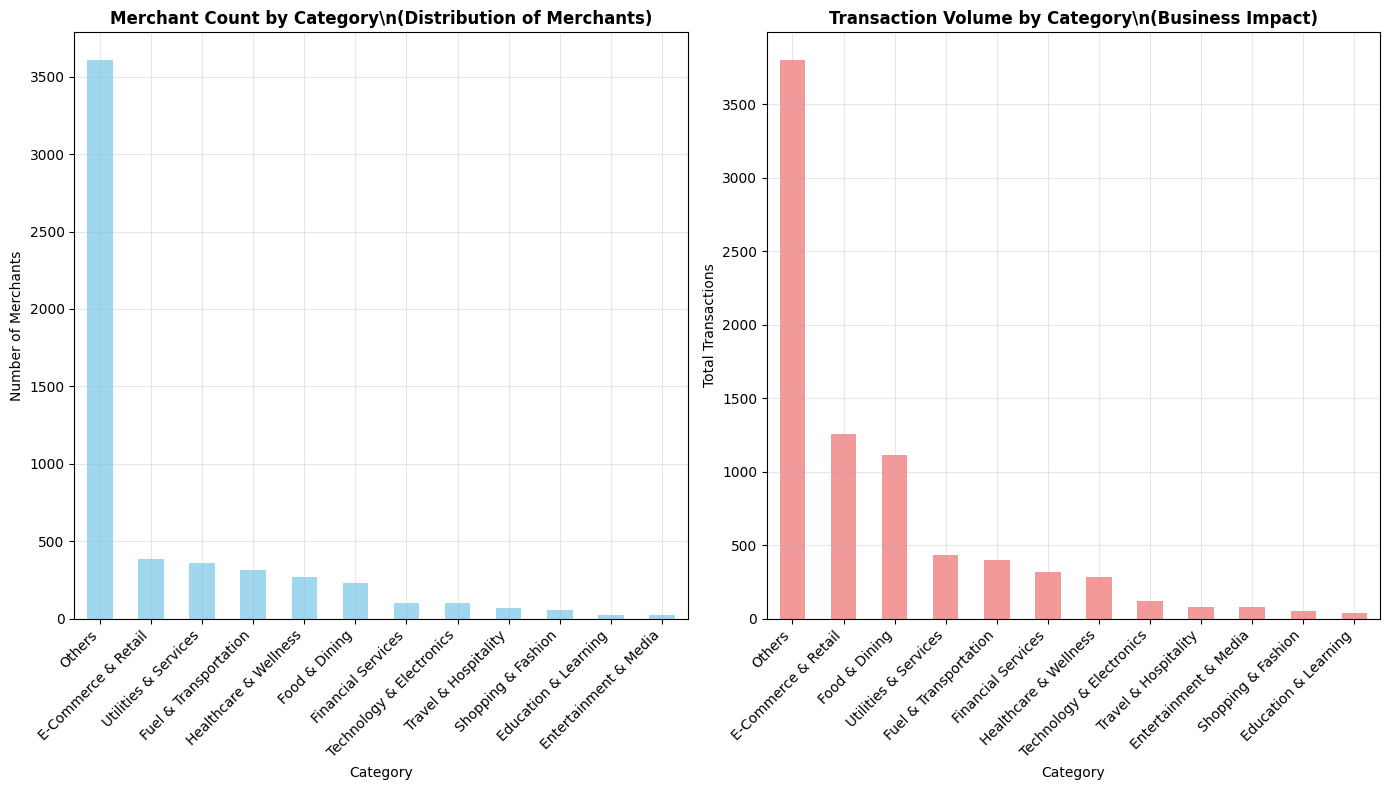

In [6]:
# Enhanced Merchant Categorization and Analysis
print("🏷️ Enhanced Merchant Categorization Analysis")
print("=" * 60)

# Debug: Check available columns and data
print(f"📊 Dataset Info:")
print(f"   • Shape: {df.shape}")
print(f"   • Available columns: {list(df.columns[:15])}{'...' if len(df.columns) > 15 else ''}")

# Check for merchant-related columns
merchant_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['merchant', 'payee', 'vendor', 'store'])]
print(f"   • Merchant-related columns: {merchant_cols}")

if 'merchant_for_analysis' in df.columns:
    unique_merchants = df['merchant_for_analysis'].nunique()
    print(f"   • Unique merchants in 'merchant_for_analysis': {unique_merchants:,}")
elif merchant_cols:
    for col in merchant_cols:
        unique_count = df[col].nunique()
        print(f"   • Unique values in '{col}': {unique_count:,}")
else:
    print("   ⚠️ No merchant-related columns found!")

print()

# Intelligent Merchant Categorization Function
def categorize_merchant(merchant_name):
    merchant_lower = str(merchant_name).lower()
    
    # Food & Dining patterns
    food_keywords = [
        'swiggy', 'zomato', 'mcdonald', 'kfc', 'pizza', 'burger', 'restaurant', 
        'cafe', 'starbucks', 'domino', 'subway', 'biryani', 'dine', 'dining', 
        'eat', 'eatsure', 'eatfit', 'chef', 'kitchen', 'delivery', 'meal', 
        'cook', 'bbq', 'barbeque', 'chai', 'tea', 'beer', 'wine', 'resto', 'lunchbox'
    ]

    # Financial Services patterns
    finance_keywords = [
        'paytm', 'phonepe', 'google pay', 'gpay', 'bank', 'pay', 'payment', 'wallet', 'upi',
        'financial', 'money', 'cash', 'credit', 'debit', 'loan', 'insurance', 'mutual fund',
        'axis', 'hdfc', 'icici', 'sbi', 'federal', 'kotak', 'yes bank', 'idfc', 'navi', 
        'cred', 'slice', 'mobikwik', 'onecard', 'rupay', 'visa', 'mastercard', 'fintech', 'investment'
    ]

    # E-Commerce & Retail patterns  
    ecommerce_keywords = [
        'amazon', 'flipkart', 'myntra', 'ajio', 'blinkit', 'instamart', 'zepto', 'jiomart', 'bigbasket',
        'shopping', 'store', 'retail', 'market', 'shop', 'mall', 'online', 'buy', 'sale', 'ecom',
        'meesho', 'snapdeal','avenue supermarts', 'ekart', 'tatacliq', 'nykaa', 'grofers', 'spencers', 'dmart', 'more retail', 
        'reliance smart', 'bbnow', 'quick commerce', 'supermarket'
    ]

    # Fuel & Transportation patterns
    transport_keywords = [
        'petrol', 'fuel', 'gas', 'station', 'uber', 'ola', 'taxi', 'cab', 'rapido', 'blusmart',
        'zoomcar', 'drivezy', 'bpcl', 'hpcl', 'ioc', 'shell', 'auto', 'car', 'bike', 'vehicle', 
        'transport', 'travel', 'ride', 'metro', 'train', 'irctc'
    ]

    # Entertainment & Media patterns
    entertainment_keywords = [
        'netflix', 'amazon prime', 'hotstar', 'spotify', 'gaming', 'bookmyshow', 'district', 'pvr', 
        'inox', 'cinema', 'movie', 'music', 'entertainment', 'stream', 'video', 'game', 
        'gaana', 'wynk', 'zee5', 'voot', 'sony liv', 'jio cinema', 'youtube', 'ticket', 'event'
    ]

    # Healthcare & Wellness patterns
    healthcare_keywords = [
        'hospital', 'clinic', 'medical', 'pharmacy', 'doctor', 'health', 'medicine', 'care',
        'wellness', 'fitness', 'gym', 'yoga', 'apollo', 'practo', '1mg', 'pharmeasy', 
        'netmeds', 'medlife', 'curefit', 'cultfit', 'diagnostic', 'pathlab', 'test', 'med'
    ]

    # Shopping & Fashion patterns
    fashion_keywords = [
        'fashion', 'clothing', 'dress', 'shirt', 'pant', 'jeans', 'kurta', 'lehenga', 'shoe',
        'footwear', 'accessories', 'beauty', 'cosmetic', 'makeup', 'lifestyle', 'apparel', 
        'wear', 'style', 'watch', 'bag', 'brand factory', 'h&m', 'zara', 'pantaloons', 'max', 
        'westside', 'biba', 'w for woman', 'fabindia', 'nykaa fashion'
    ]

    # Utilities & Services patterns
    utility_keywords = [
        'electric', 'electricity', 'water', 'internet', 'telecom', 'broadband', 'fiber',
        'service', 'utility', 'bill', 'recharge', 'subscription', 'airtel', 'jio', 'vi',
        'bsnl', 'tata sky', 'dth', 'cylinder', 'gas', 'lpg', 'bpl', 'ebill', 'postpaid', 
        'prepaid', 'data card', 'tv'
    ]

    # Education & Learning patterns
    education_keywords = [
        'school', 'college', 'university', 'education', 'learning', 'course', 'book', 'study',
        'training', 'institute', 'academy', 'byjus', 'unacademy', 'upgrad', 'vedantu', 
        'coursera', 'udemy', 'khan academy', 'textbook', 'edtech', 'mock test', 'coaching'
    ]

    # Travel & Hospitality patterns
    travel_keywords = [
        'hotel', 'resort', 'booking', 'tourism', 'vacation', 'trip', 'holiday', 'stay', 
        'accommodation', 'flight', 'airline', 'railway', 'irctc', 'yatra', 'makemytrip', 
        'goibibo', 'oyo', 'agoda', 'tripadvisor', 'visa', 'travelxp', 'cleartrip', 'hostel'
    ]

    # Technology & Electronics patterns
    tech_keywords = [
        'electronic', 'mobile', 'laptop', 'computer', 'tech', 'digital', 'software', 'app', 
        'gadget', 'device', 'hardware', 'phone', 'headphone', 'charger', 'camera', 'tv',
        'electronics', 'lenovo', 'asus', 'dell', 'hp', 'acer', 'xiaomi', 'realme', 'samsung',
        'vivo', 'boat', 'oneplus'
    ]

    
    # Check categories in order of specificity
    if any(keyword in merchant_lower for keyword in food_keywords):
        return 'Food & Dining'
    elif any(keyword in merchant_lower for keyword in finance_keywords):
        return 'Financial Services'
    elif any(keyword in merchant_lower for keyword in ecommerce_keywords):
        return 'E-Commerce & Retail'
    elif any(keyword in merchant_lower for keyword in transport_keywords):
        return 'Fuel & Transportation'
    elif any(keyword in merchant_lower for keyword in entertainment_keywords):
        return 'Entertainment & Media'
    elif any(keyword in merchant_lower for keyword in healthcare_keywords):
        return 'Healthcare & Wellness'
    elif any(keyword in merchant_lower for keyword in fashion_keywords):
        return 'Shopping & Fashion'
    elif any(keyword in merchant_lower for keyword in utility_keywords):
        return 'Utilities & Services'
    elif any(keyword in merchant_lower for keyword in education_keywords):
        return 'Education & Learning'
    elif any(keyword in merchant_lower for keyword in travel_keywords):
        return 'Travel & Hospitality'
    elif any(keyword in merchant_lower for keyword in tech_keywords):
        return 'Technology & Electronics'
    else:
        return 'Others'

# Enhanced Merchant Consolidation and Categorization
def consolidate_merchant_name(merchant_name):
    """
    Consolidate similar merchant names into single entities
    E.g., 'Zomato Ltd', 'Zomato private Limited', 'Zomato Online Order' -> 'Zomato'
    """
    merchant_lower = str(merchant_name).lower().strip()
    
    # Remove common suffixes and prefixes
    cleanup_patterns = [
        ' ltd', ' limited', ' pvt', ' private', ' inc', ' corporation', ' corp',
        ' online', ' order', ' delivery', ' pay', ' payment', ' india'
    ]
    
    for pattern in cleanup_patterns:
        merchant_lower = merchant_lower.replace(pattern, '')
    
    # Specific merchant consolidations
    consolidated_merchants = {
        # Food delivery platforms
        'swiggy': 'Swiggy',
        'zomato': 'Zomato', 
        'zomato online order': 'Zomato',
        'zomato private': 'Zomato',
        
        # E-commerce platforms
        'amazon': 'Amazon',
        'amazon pay': 'Amazon Pay',
        'amazon india': 'Amazon',
        'flipkart': 'Flipkart',
        'myntra': 'Myntra',
        
        # Financial services
        'paytm': 'PayTM',
        'phonepe': 'PhonePe',
        'phone pe': 'PhonePe',
        'axis bank': 'Axis Bank',
        'hdfc': 'HDFC Bank',
        'icici': 'ICICI Bank',
        'sbi': 'SBI',
        
        # Transportation
        'uber': 'Uber',
        'ola': 'Ola',
        'rapido': 'Rapido',
        'blusmart': 'BluSmart',
        'zoomcar': 'Zoomcar',
        'drivezy': 'Drivezy',
        'bpcl': 'BPCL',
        'hpcl': 'HPCL',
        'ioc': 'IOC',

        
        # Others
        'blinkit': 'Blinkit',
        'zepto': 'Zepto'
    }
    
    # Check for exact matches first
    for key, value in consolidated_merchants.items():
        if key in merchant_lower:
            return value
    
    # If no consolidation needed, return cleaned up version with proper capitalization
    return ' '.join(word.capitalize() for word in merchant_lower.split())

# Create or use existing merchant stats
if 'merchant_stats' not in locals() or len(merchant_stats) == 0:
    print("🔄 Creating merchant statistics from scratch...")
    
    # Ensure we have merchant_for_analysis column
    if 'merchant_for_analysis' not in df.columns:
        # Create merchant_for_analysis from available data
        if 'payee' in df.columns:
            df['merchant_for_analysis'] = df['payee'].fillna('Unknown').astype(str).str.strip()
        elif 'merchant' in df.columns:
            df['merchant_for_analysis'] = df['merchant'].fillna('Unknown').astype(str).str.strip()
        else:
            print("❌ No merchant column found in dataset!")
            merchant_stats = pd.DataFrame()
    
    if 'merchant_for_analysis' in df.columns:
        # Calculate merchant statistics
        merchant_stats = df.groupby('merchant_for_analysis').agg({
            'transactionamount': ['count', 'sum', 'mean', 'std'],
            'user_id': 'nunique',
            'transactiondatetime': ['min', 'max']
        }).round(2)
        
        merchant_stats.columns = ['txn_count', 'total_value', 'avg_amount', 
                                 'amount_std', 'unique_users', 'first_txn', 'last_txn']
        
        # Calculate additional metrics
        total_days = (pd.to_datetime(df['transactiondatetime']).max() - 
                     pd.to_datetime(df['transactiondatetime']).min()).days + 1
        merchant_stats['txn_per_day'] = (merchant_stats['txn_count'] / total_days).round(2)
        merchant_stats['user_penetration'] = (merchant_stats['unique_users'] / 
                                             df['user_id'].nunique() * 100).round(2)
        
        print(f"✅ Created merchant statistics for {len(merchant_stats):,} merchants")
    else:
        merchant_stats = pd.DataFrame()

# Apply consolidation to merchant stats  
if len(merchant_stats) > 0:
    print("🔄 Consolidating similar merchant names...")
    
    # Create consolidated merchant names
    merchant_stats['consolidated_name'] = merchant_stats.index.map(consolidate_merchant_name)
    
    # Group by consolidated names and aggregate stats
    consolidated_stats = merchant_stats.groupby('consolidated_name').agg({
        'txn_count': 'sum',
        'total_value': 'sum', 
        'avg_amount': 'mean',
        'amount_std': 'mean',
        'unique_users': 'sum',  # This might double count, but gives us reach
        'txn_per_day': 'mean'
    }).round(2)
    
    # Recalculate metrics for consolidated data
    total_days = (pd.to_datetime(df['transactiondatetime']).max() - 
                 pd.to_datetime(df['transactiondatetime']).min()).days + 1
    consolidated_stats['txn_per_day'] = (consolidated_stats['txn_count'] / total_days).round(2)
    consolidated_stats['user_penetration'] = (consolidated_stats['unique_users'] / df['user_id'].nunique() * 100).round(2)
    
    # Apply categorization to consolidated merchants
    consolidated_stats['category'] = consolidated_stats.index.map(categorize_merchant)
    
    # Enhanced Popularity Score Calculation for consolidated merchants
    print("🎯 Calculating Enhanced Popularity Scores for Consolidated Merchants...")
    
    # Ensure unique ranks by using dense ranking method
    import numpy as np
    np.random.seed(42)  # For reproducibility
    
    volume_rank = consolidated_stats['txn_count'].rank(pct=True, method='dense')
    user_rank = consolidated_stats['user_penetration'].rank(pct=True, method='dense') 
    consistency_rank = consolidated_stats['txn_per_day'].rank(pct=True, method='dense')
    
    # Enhanced scoring with better distribution
    consolidated_stats['popularity_score'] = (
        0.4 * volume_rank +      # 40% weight on transaction volume
        0.3 * user_rank +        # 30% weight on user reach  
        0.3 * consistency_rank   # 30% weight on daily consistency
    ).round(4)
    
    # Sort by popularity score
    consolidated_stats = consolidated_stats.sort_values('popularity_score', ascending=False)
    
    # Update merchant_stats to use consolidated data
    merchant_stats = consolidated_stats.copy()
    
    print(f"✅ Consolidated and categorized {len(merchant_stats)} unique merchants into {merchant_stats['category'].nunique()} categories")
    
    # Show consolidation impact
    original_count = len(df['merchant_for_analysis'].unique())
    consolidated_count = len(merchant_stats)
    reduction_pct = ((original_count - consolidated_count) / original_count) * 100
    print(f"   📈 Consolidation Impact: Reduced from {original_count:,} to {consolidated_count:,} merchants ({reduction_pct:.1f}% reduction)")
    
    # Category Distribution Analysis
    category_stats = merchant_stats.groupby('category').agg({
        'txn_count': ['count', 'sum', 'mean'],
        'total_value': ['sum', 'mean'],
        'popularity_score': ['mean', 'max']
    }).round(2)
    
    category_stats.columns = ['merchant_count', 'total_txns', 'avg_txns_per_merchant', 
                             'total_revenue', 'avg_revenue_per_merchant', 'avg_popularity', 'max_popularity']
    
    print(f"\\n📊 Category Distribution Analysis:")
    for category, stats in category_stats.iterrows():
        print(f"   {category}: {stats['merchant_count']} merchants, {stats['total_txns']:,} transactions")
    
    # Display enhanced top 30 consolidated merchants with categories  
    print(f"\\n🏅 TOP 30 CONSOLIDATED MERCHANTS WITH CATEGORIES:")
    top_30_enhanced = merchant_stats.head(30)[['category', 'txn_count', 'total_value', 'user_penetration', 'avg_amount', 'popularity_score']]
    
    # Format for better display
    top_30_display = top_30_enhanced.copy()
    top_30_display['total_value'] = top_30_display['total_value'].apply(lambda x: f"₹{x:,.0f}")
    top_30_display['avg_amount'] = top_30_display['avg_amount'].apply(lambda x: f"₹{x:.0f}")
    top_30_display['user_penetration'] = top_30_display['user_penetration'].apply(lambda x: f"{x:.2f}%")
    
    display(top_30_display)
    
    # Show category distribution
    plt.figure(figsize=(14, 8))
    category_counts = merchant_stats['category'].value_counts()
    
    plt.subplot(1, 2, 1)
    category_counts.plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Merchant Count by Category\\n(Distribution of Merchants)', fontsize=12, fontweight='bold')
    plt.xlabel('Category')
    plt.ylabel('Number of Merchants')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Category transaction volume
    plt.subplot(1, 2, 2)
    category_txns = merchant_stats.groupby('category')['txn_count'].sum().sort_values(ascending=False)
    category_txns.plot(kind='bar', color='lightcoral', alpha=0.8)
    plt.title('Transaction Volume by Category\\n(Business Impact)', fontsize=12, fontweight='bold')
    plt.xlabel('Category')
    plt.ylabel('Total Transactions')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No merchant statistics available for categorization")


In [ ]:
# Enhanced MCC-Based Merchant Categorization System
print("🏷️ Enhanced MCC-Based Merchant Categorization System")
print("=" * 60)
print("📊 Reference: NPCI RuPay Merchant Category Code Standards")
print("🔗 Source: https://www.npci.org.in/what-we-do/rupay/merchant-category-code")

import re

# Enhanced MCC-Based Merchant Categorization Function
def categorize_merchant_by_mcc(mcc_code):
    """
    Categorize merchants using NPCI MCC (Merchant Category Code) standards
    Reference: https://www.npci.org.in/what-we-do/rupay/merchant-category-code
    """
    if pd.isna(mcc_code):
        return 'Others'
    
    # Convert to string and handle different formats
    mcc_str = str(mcc_code).strip()
    
    # Extract numeric MCC if it's in a complex format
    mcc_match = re.search(r'"mccCode":"(\d+)"', mcc_str)
    if mcc_match:
        mcc_str = mcc_match.group(1)
    
    try:
        mcc = int(mcc_str)
    except (ValueError, TypeError):
        return 'Others'
    
    # MCC-based categorization following NPCI standards
    # Food & Dining (High transacting - NPCI reference)
    if mcc in [5812, 5814, 5813, 5811, 5462]:  # Restaurants, Fast Food, Drinking Places, Bakeries
        return 'Food & Dining'
    
    # Grocery & Supermarkets (High transacting - NPCI reference) 
    elif mcc in [5411, 5499, 5441]:  # Grocery Stores, Misc Food Stores, Candy/Confectionery
        return 'Grocery & Supermarkets'
    
    # Fuel & Transportation (High transacting - NPCI reference)
    elif mcc in [5541, 4111, 4112, 4121, 4214]:  # Service Stations, Transportation, Taxis, Freight
        return 'Fuel & Transportation'
    
    # Government & Utilities (High transacting - NPCI reference)
    elif mcc in [9399, 4900]:  # Government Services, Utilities
        return 'Government & Utilities'
    
    # Healthcare & Medical (High transacting - NPCI reference)
    elif mcc in [8062, 5912, 5047, 8011, 8021, 8041, 8049, 8071, 8099]:  # Hospitals, Pharmacies, Medical Equipment
        return 'Healthcare & Medical'
    
    # Retail & Department Stores (High transacting - NPCI reference)
    elif mcc in [5311, 5399, 5331, 5999]:  # Department Stores, General Merchandise, Variety Stores
        return 'Retail & Department Stores'
    
    # Fashion & Apparel (Medium transacting - NPCI reference)
    elif mcc in [5651, 5691, 5699, 5661, 5631, 5137]:  # Clothing Stores, Apparel, Shoes, Uniforms
        return 'Fashion & Apparel'
    
    # Electronics & Technology (Medium transacting - NPCI reference)
    elif mcc in [5732, 5815, 5816, 5817, 5818, 5722]:  # Electronics, Digital Goods, Household Appliances
        return 'Electronics & Technology'
    
    # Telecommunications (Medium transacting - NPCI reference)
    elif mcc in [4814, 4812, 4813]:  # Telecom Services, Equipment
        return 'Telecommunications'
    
    # Financial Services 
    elif mcc in [6010, 6011, 6012, 6300, 6513, 6540]:  # Banks, Financial Institutions, Insurance, POI Funding
        return 'Financial Services'
    
    # Travel & Hospitality (Medium transacting - NPCI reference)
    elif mcc in [7011, 4722, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009]:  # Hotels, Travel Agencies, Airlines
        return 'Travel & Hospitality'
    
    # Entertainment & Media (Medium transacting - NPCI reference)
    elif mcc in [7832, 7994, 7999, 4899, 7929, 7933]:  # Theaters, Video Games, Cable TV, Entertainment
        return 'Entertainment & Media'
    
    # Education & Learning
    elif mcc in [8211, 8220, 8299, 5942, 5943]:  # Schools, Colleges, Educational Services, Books
        return 'Education & Learning'
    
    # Jewelry & Luxury (Medium transacting - NPCI reference)
    elif mcc in [5944, 5945, 5946]:  # Jewelry, Watches, Clocks
        return 'Jewelry & Luxury'
    
    # Automotive & Vehicle Services
    elif mcc in [5511, 5521, 5531, 5532, 5533, 5561, 5571, 5592, 5598, 5599]:  # Auto Dealers, Parts, Repair
        return 'Automotive & Services'
    
    # Alcohol & Beverages (High transacting - NPCI reference)
    elif mcc in [5921]:  # Package Stores (Beer, Wine, Liquor)
        return 'Alcohol & Beverages'
    
    # Business & Professional Services
    elif mcc in [7399, 8931, 8999, 7296, 7298]:  # Business Services, Professional Services
        return 'Business & Professional Services'
    
    # Home & Hardware
    elif mcc in [5251, 5261, 5712, 5713, 5714, 5718, 5719]:  # Hardware, Lawn/Garden, Furniture, Glass/Paint
        return 'Home & Hardware'
    
    # Specialty Retail
    elif mcc in [5451, 5422, 5975, 5976, 5977, 5978]:  # Dairy, Meat, Labor/Civil Organizations
        return 'Specialty Retail'
    
    # Unknown/Others for unclassified MCCs
    else:
        return 'Others'

print("✅ MCC categorization functions defined successfully!")
print("📝 Ready to extract MCC codes and apply NPCI-standard categorization")


## 🔬 Step 1: Category-Based Data Preparation

### 📊 **Data Filtering Strategy**

Before implementing RFM per category, we need to:

1. **Focus on Meaningful Categories**: Use top merchant categories with sufficient transaction volume
2. **User Filtering**: Include only users with meaningful engagement in each category
3. **Transaction Validation**: Ensure clean, successful transactions for accurate RFM calculation

### 🎯 **Implementation Steps:**

1. **Category Selection**: Filter for top 6 merchant categories based on transaction volume
2. **User Activity Threshold**: Include users with at least 1 transaction in the category
3. **Data Quality**: Ensure we have valid transaction dates, amounts, and user IDs
4. **Category Mapping**: Map each transaction to its merchant category for segmented analysis


In [7]:
# Step 1: Category-Based Data Preparation for RFM Analysis
print("🔬 Step 1: Category-Based Data Preparation for RFM Analysis")
print("=" * 70)

# Ensure we have the merchant statistics from previous analysis
if 'merchant_stats' in locals() and len(merchant_stats) > 0:
    print("✅ Using existing merchant statistics and categories")
    
    # Get top categories by transaction volume
    category_volume = merchant_stats.groupby('category')['txn_count'].sum().sort_values(ascending=False)
    print(f"\n📊 Category Transaction Volumes:")
    for category, volume in category_volume.head(8).items():
        print(f"   • {category}: {volume:,} transactions")
    
    # Select top 6 categories for detailed RFM analysis (excluding 'Others')
    top_categories = [cat for cat in category_volume.index if cat != 'Others'][:6]
    print(f"\n🎯 Selected Categories for RFM Analysis: {len(top_categories)}")
    for i, category in enumerate(top_categories, 1):
        print(f"   {i}. {category}")
    
    # Create merchant-to-category mapping
    merchant_category_mapping = merchant_stats['category'].to_dict()
    
    # Apply category mapping to the main dataframe
    df['merchant_category'] = df['merchant_for_analysis'].map(merchant_category_mapping)
    df['merchant_category'] = df['merchant_category'].fillna('Others')
    
    # Filter for transactions in our selected categories
    df_rfm = df[df['merchant_category'].isin(top_categories)].copy()
    
    print(f"\n📈 Data Filtering Results:")
    print(f"   • Original transactions: {len(df):,}")
    print(f"   • Transactions in top categories: {len(df_rfm):,}")
    print(f"   • Coverage: {len(df_rfm)/len(df)*100:.1f}%")
    print(f"   • Unique users in filtered data: {df_rfm['user_id'].nunique():,}")
    
    # Show category distribution in filtered data
    print(f"\n🏷️ Category Distribution in RFM Dataset:")
    category_dist = df_rfm['merchant_category'].value_counts()
    for category, count in category_dist.items():
        percentage = count / len(df_rfm) * 100
        users = df_rfm[df_rfm['merchant_category'] == category]['user_id'].nunique()
        print(f"   • {category}: {count:,} txns ({percentage:.1f}%) | {users:,} users")
        
else:
    print("❌ Merchant statistics not available. Please run merchant analysis first.")
    top_categories = []
    df_rfm = pd.DataFrame()

print(f"\n✅ Data preparation complete. Ready for category-specific RFM analysis!")


🔬 Step 1: Category-Based Data Preparation for RFM Analysis
✅ Using existing merchant statistics and categories

📊 Category Transaction Volumes:
   • Others: 3,799 transactions
   • E-Commerce & Retail: 1,255 transactions
   • Food & Dining: 1,115 transactions
   • Utilities & Services: 431 transactions
   • Fuel & Transportation: 402 transactions
   • Financial Services: 314 transactions
   • Healthcare & Wellness: 285 transactions
   • Technology & Electronics: 117 transactions

🎯 Selected Categories for RFM Analysis: 6
   1. E-Commerce & Retail
   2. Food & Dining
   3. Utilities & Services
   4. Fuel & Transportation
   5. Financial Services
   6. Healthcare & Wellness

📈 Data Filtering Results:
   • Original transactions: 7,968
   • Transactions in top categories: 471
   • Coverage: 5.9%
   • Unique users in filtered data: 463

🏷️ Category Distribution in RFM Dataset:
   • E-Commerce & Retail: 141 txns (29.9%) | 139 users
   • Food & Dining: 119 txns (25.3%) | 119 users
   • Fuel &

## ⚡ Step 2: Category-Specific RFM Calculation Engine

### 🧮 **RFM Metrics Per Category**

For each category, we calculate RFM metrics **separately** for users active in that category:

#### **Recency (R)**: Days since last transaction *within the category*
- **Context**: How recently did the user transact in Food vs Finance vs E-commerce?
- **Calculation**: `analysis_date - max(transaction_date)` within each category
- **Scoring**: 1-4 scale (4 = most recent within category)

#### **Frequency (F)**: Number of transactions *within the category*  
- **Context**: How often does the user transact in this specific category?
- **Calculation**: `count(transactions)` within each category
- **Scoring**: 1-4 scale (4 = most frequent within category)

#### **Monetary (M)**: Total spending *within the category*
- **Context**: How much has the user spent specifically in this category?
- **Calculation**: `sum(transaction_amounts)` within each category  
- **Scoring**: 1-4 scale (4 = highest spender within category)

### **Category-Specific Ranking**

Users are ranked against **peers within the same category**, not globally.

- A user spending ₹5000 on food might be a "Food Champion" (top 25% in food category)
- The same user spending ₹5000 on luxury goods might be "Occasional Shopper" (bottom 50% in luxury category)
- This creates **context-aware personas** that reflect true category expertise


In [8]:
# Step 2: Category-Specific RFM Calculation Engine
print("⚡ Step 2: Category-Specific RFM Calculation Engine")
print("=" * 70)

# Initialize storage for category-specific RFM results
category_rfm_results = {}
category_user_personas = {}

# Set analysis date as the most recent transaction date
analysis_date = pd.to_datetime(df_rfm['transactiondatetime']).max()
print(f"📅 Analysis Date: {analysis_date.strftime('%Y-%m-%d')}")

if len(top_categories) > 0 and len(df_rfm) > 0:
    
    print(f"\n🔄 Processing {len(top_categories)} categories for RFM analysis...")
    
    for category in top_categories:
        print(f"\n🎯 Processing: {category}")
        print("-" * 50)
        
        # Filter transactions for this specific category
        category_data = df_rfm[df_rfm['merchant_category'] == category].copy()
        
        if len(category_data) == 0:
            print(f"   ⚠️ No transactions found for {category}")
            continue
            
        print(f"   📊 Category Data: {len(category_data):,} transactions, {category_data['user_id'].nunique():,} users")
        
        # Calculate RFM metrics for users in this category
        print("   🧮 Calculating RFM metrics...")
        
        category_rfm = category_data.groupby('user_id').agg({
            'transactiondatetime': lambda x: (analysis_date - pd.to_datetime(x).max()).days,  # Recency
            'jupiter_transaction_id': 'count',  # Frequency  
            'transactionamount': 'sum'  # Monetary
        }).round(2)
        
        # Rename columns for clarity
        category_rfm.columns = ['recency', 'frequency', 'monetary']
        
        # Calculate category-specific RFM scores (quartile-based ranking within category)
        print("   📊 Calculating category-specific scores (1-4 scale)...")
        
        try:
            # Use quartile-based scoring within this category
            category_rfm['r_score'] = pd.qcut(category_rfm['recency'].rank(method='first'), 
                                            4, labels=[4,3,2,1])  # Reverse: lower recency = higher score
            category_rfm['f_score'] = pd.qcut(category_rfm['frequency'].rank(method='first'), 
                                            4, labels=[1,2,3,4])  # Higher frequency = higher score
            category_rfm['m_score'] = pd.qcut(category_rfm['monetary'].rank(method='first'), 
                                            4, labels=[1,2,3,4])  # Higher monetary = higher score
        except ValueError as e:
            # Handle cases with insufficient data diversity (too few unique values)
            print(f"   ⚠️ Using simplified scoring due to limited data diversity in {category}")
            category_rfm['r_score'] = pd.cut(category_rfm['recency'], bins=4, labels=[4,3,2,1])
            category_rfm['f_score'] = pd.cut(category_rfm['frequency'], bins=4, labels=[1,2,3,4])
            category_rfm['m_score'] = pd.cut(category_rfm['monetary'], bins=4, labels=[1,2,3,4])
        
        # Create RFM segment strings (e.g., "444", "123", etc.)
        category_rfm['rfm_segment'] = (category_rfm['r_score'].astype(str) + 
                                     category_rfm['f_score'].astype(str) + 
                                     category_rfm['m_score'].astype(str))
        
        # Apply category-specific persona mapping
        def categorize_rfm_by_category(segment, category_name):
            """Map RFM segments to category-specific personas"""
            
            # Base RFM segment mapping
            base_personas = {
                '444': 'Champions', '443': 'Champions', '434': 'Champions', '344': 'Champions',
                '442': 'Loyal Users', '424': 'Loyal Users', '441': 'Loyal Users', '414': 'Loyal Users',
                '433': 'Potential', '432': 'Potential', '423': 'Potential', '422': 'Potential',
                '244': 'New Users', '243': 'New Users', '234': 'New Users', '144': 'New Users',
                '343': 'Promising', '342': 'Promising', '333': 'Promising', '332': 'Promising',
                '241': 'Need Attention', '231': 'Need Attention', '221': 'Need Attention'
            }
            
            base_persona = base_personas.get(segment, 'At Risk')
            
            # Category-specific persona naming
            category_personas = {
                'Food & Dining': {
                    'Champions': 'Food Champions', 'Loyal Users': 'Regular Diners',
                    'Potential': 'Food Explorers', 'New Users': 'New Foodies',
                    'Promising': 'Growing Diners', 'Need Attention': 'Occasional Diners',
                    'At Risk': 'Lapsed Foodies'
                },
                'Financial Services': {
                    'Champions': 'Finance Power Users', 'Loyal Users': 'Banking Loyalists', 
                    'Potential': 'Payment Adopters', 'New Users': 'Fintech Newbies',
                    'Promising': 'Growing Users', 'Need Attention': 'Light Users',
                    'At Risk': 'Dormant Users'
                },
                'E-Commerce & Retail': {
                    'Champions': 'Shopping Champions', 'Loyal Users': 'Frequent Buyers',
                    'Potential': 'Occasional Shoppers', 'New Users': 'New Shoppers', 
                    'Promising': 'Growing Buyers', 'Need Attention': 'Window Shoppers',
                    'At Risk': 'Cart Abandoners'
                },
                'Fuel & Transportation': {
                    'Champions': 'Daily Commuters', 'Loyal Users': 'Regular Travelers',
                    'Potential': 'Weekend Drivers', 'New Users': 'New Commuters',
                    'Promising': 'Growing Travelers', 'Need Attention': 'Occasional Drivers',
                    'At Risk': 'Inactive Commuters'
                },
                'Entertainment & Media': {
                    'Champions': 'Entertainment Enthusiasts', 'Loyal Users': 'Regular Streamers',
                    'Potential': 'Content Explorers', 'New Users': 'New Subscribers',
                    'Promising': 'Growing Viewers', 'Need Attention': 'Light Users',
                    'At Risk': 'Unsubscribed Users'
                },
                'Education & Learning': {
                    'Champions': 'Learning Champions', 'Loyal Users': 'Course Enthusiasts',
                    'Potential': 'Knowledge Seekers', 'New Users': 'New Learners',
                    'Promising': 'Growing Students', 'Need Attention': 'Casual Learners',
                    'At Risk': 'Dormant Learners'
                }
            }
            
            return category_personas.get(category_name, {}).get(base_persona, f"{base_persona} ({category_name})")
        
        # Apply persona mapping
        category_rfm['persona'] = category_rfm['rfm_segment'].apply(
            lambda x: categorize_rfm_by_category(x, category)
        )
        
        # Add category label for reference
        category_rfm['category'] = category
        
        # Store results
        category_rfm_results[category] = category_rfm
        
        # Store persona distribution for this category
        persona_counts = category_rfm['persona'].value_counts()
        category_user_personas[category] = persona_counts
        
        # Display category summary
        print(f"   ✅ Analysis Complete: {len(category_rfm):,} users segmented")
        print(f"      📈 RFM Ranges:")
        print(f"         • Recency: {category_rfm['recency'].min()}-{category_rfm['recency'].max()} days")
        print(f"         • Frequency: {category_rfm['frequency'].min()}-{category_rfm['frequency'].max()} transactions")
        print(f"         • Monetary: ₹{category_rfm['monetary'].min():.0f}-₹{category_rfm['monetary'].max():,.0f}")
        print(f"      🏆 Top Persona: {persona_counts.index[0]} ({persona_counts.iloc[0]} users)")

    print(f"\n✅ Category-Specific RFM Analysis Complete!")
    print(f"   🎯 Categories Processed: {len(category_rfm_results)}")
    print(f"   👥 Total Segmented Users: {sum(len(rfm) for rfm in category_rfm_results.values())}")
    print(f"   🏷️ Unique Personas Created: {sum(len(personas) for personas in category_user_personas.values())}")
    
else:
    print("❌ No categories or data available for RFM analysis")

print("\n🚀 Ready for visualization and insights generation!")


⚡ Step 2: Category-Specific RFM Calculation Engine
📅 Analysis Date: 2025-06-28

🔄 Processing 6 categories for RFM analysis...

🎯 Processing: E-Commerce & Retail
--------------------------------------------------
   📊 Category Data: 141 transactions, 139 users
   🧮 Calculating RFM metrics...
   📊 Calculating category-specific scores (1-4 scale)...
   ✅ Analysis Complete: 139 users segmented
      📈 RFM Ranges:
         • Recency: 0-33 days
         • Frequency: 1-2 transactions
         • Monetary: ₹10-₹5,000
      🏆 Top Persona: Cart Abandoners (92 users)

🎯 Processing: Food & Dining
--------------------------------------------------
   📊 Category Data: 119 transactions, 119 users
   🧮 Calculating RFM metrics...
   📊 Calculating category-specific scores (1-4 scale)...
   ✅ Analysis Complete: 119 users segmented
      📈 RFM Ranges:
         • Recency: 0-33 days
         • Frequency: 1-1 transactions
         • Monetary: ₹12-₹4,600
      🏆 Top Persona: Lapsed Foodies (75 users)

🎯 Proces

## 📊 Step 3: Category-Specific RFM Visualizations & Analysis

### 🎨 **Comprehensive Visualization Strategy**

Now that we have category-specific RFM data, we'll create visualizations that showcase:

1. **Category Participation**: How many users are active in each category
2. **RFM Quality Distribution**: Comparing user engagement quality across categories  
3. **Persona Distribution**: Category-specific user personas and their sizes
4. **Value Analysis**: Monetary patterns by category and RFM scores
5. **Percentile Mapping**: Elite/Premium/Regular/Basic user tiers within categories
6. **Cross-Category Engagement**: Multi-category user behavior patterns

### 📈 **Visualization Goals:**

- **Business Intelligence**: Identify high-value categories and user segments
- **Persona Validation**: Confirm that category-specific personas make sense
- **Cross-Selling Opportunities**: Spot users who could expand to other categories
- **Resource Allocation**: Focus marketing efforts on the most promising segments


📊 Step 3: Category-Specific RFM Visualizations & Analysis
🎨 Creating comprehensive RFM visualizations...
   📈 Chart 1: Category Participation Analysis...
   📊 Chart 2: RFM Quality Comparison...
   🏆 Chart 3: Category-Specific Personas...
   💰 Chart 4: Monetary Value Analysis...
   📊 Chart 5: Percentile-based User Mapping...
   🔄 Chart 6: Cross-Category Analysis...


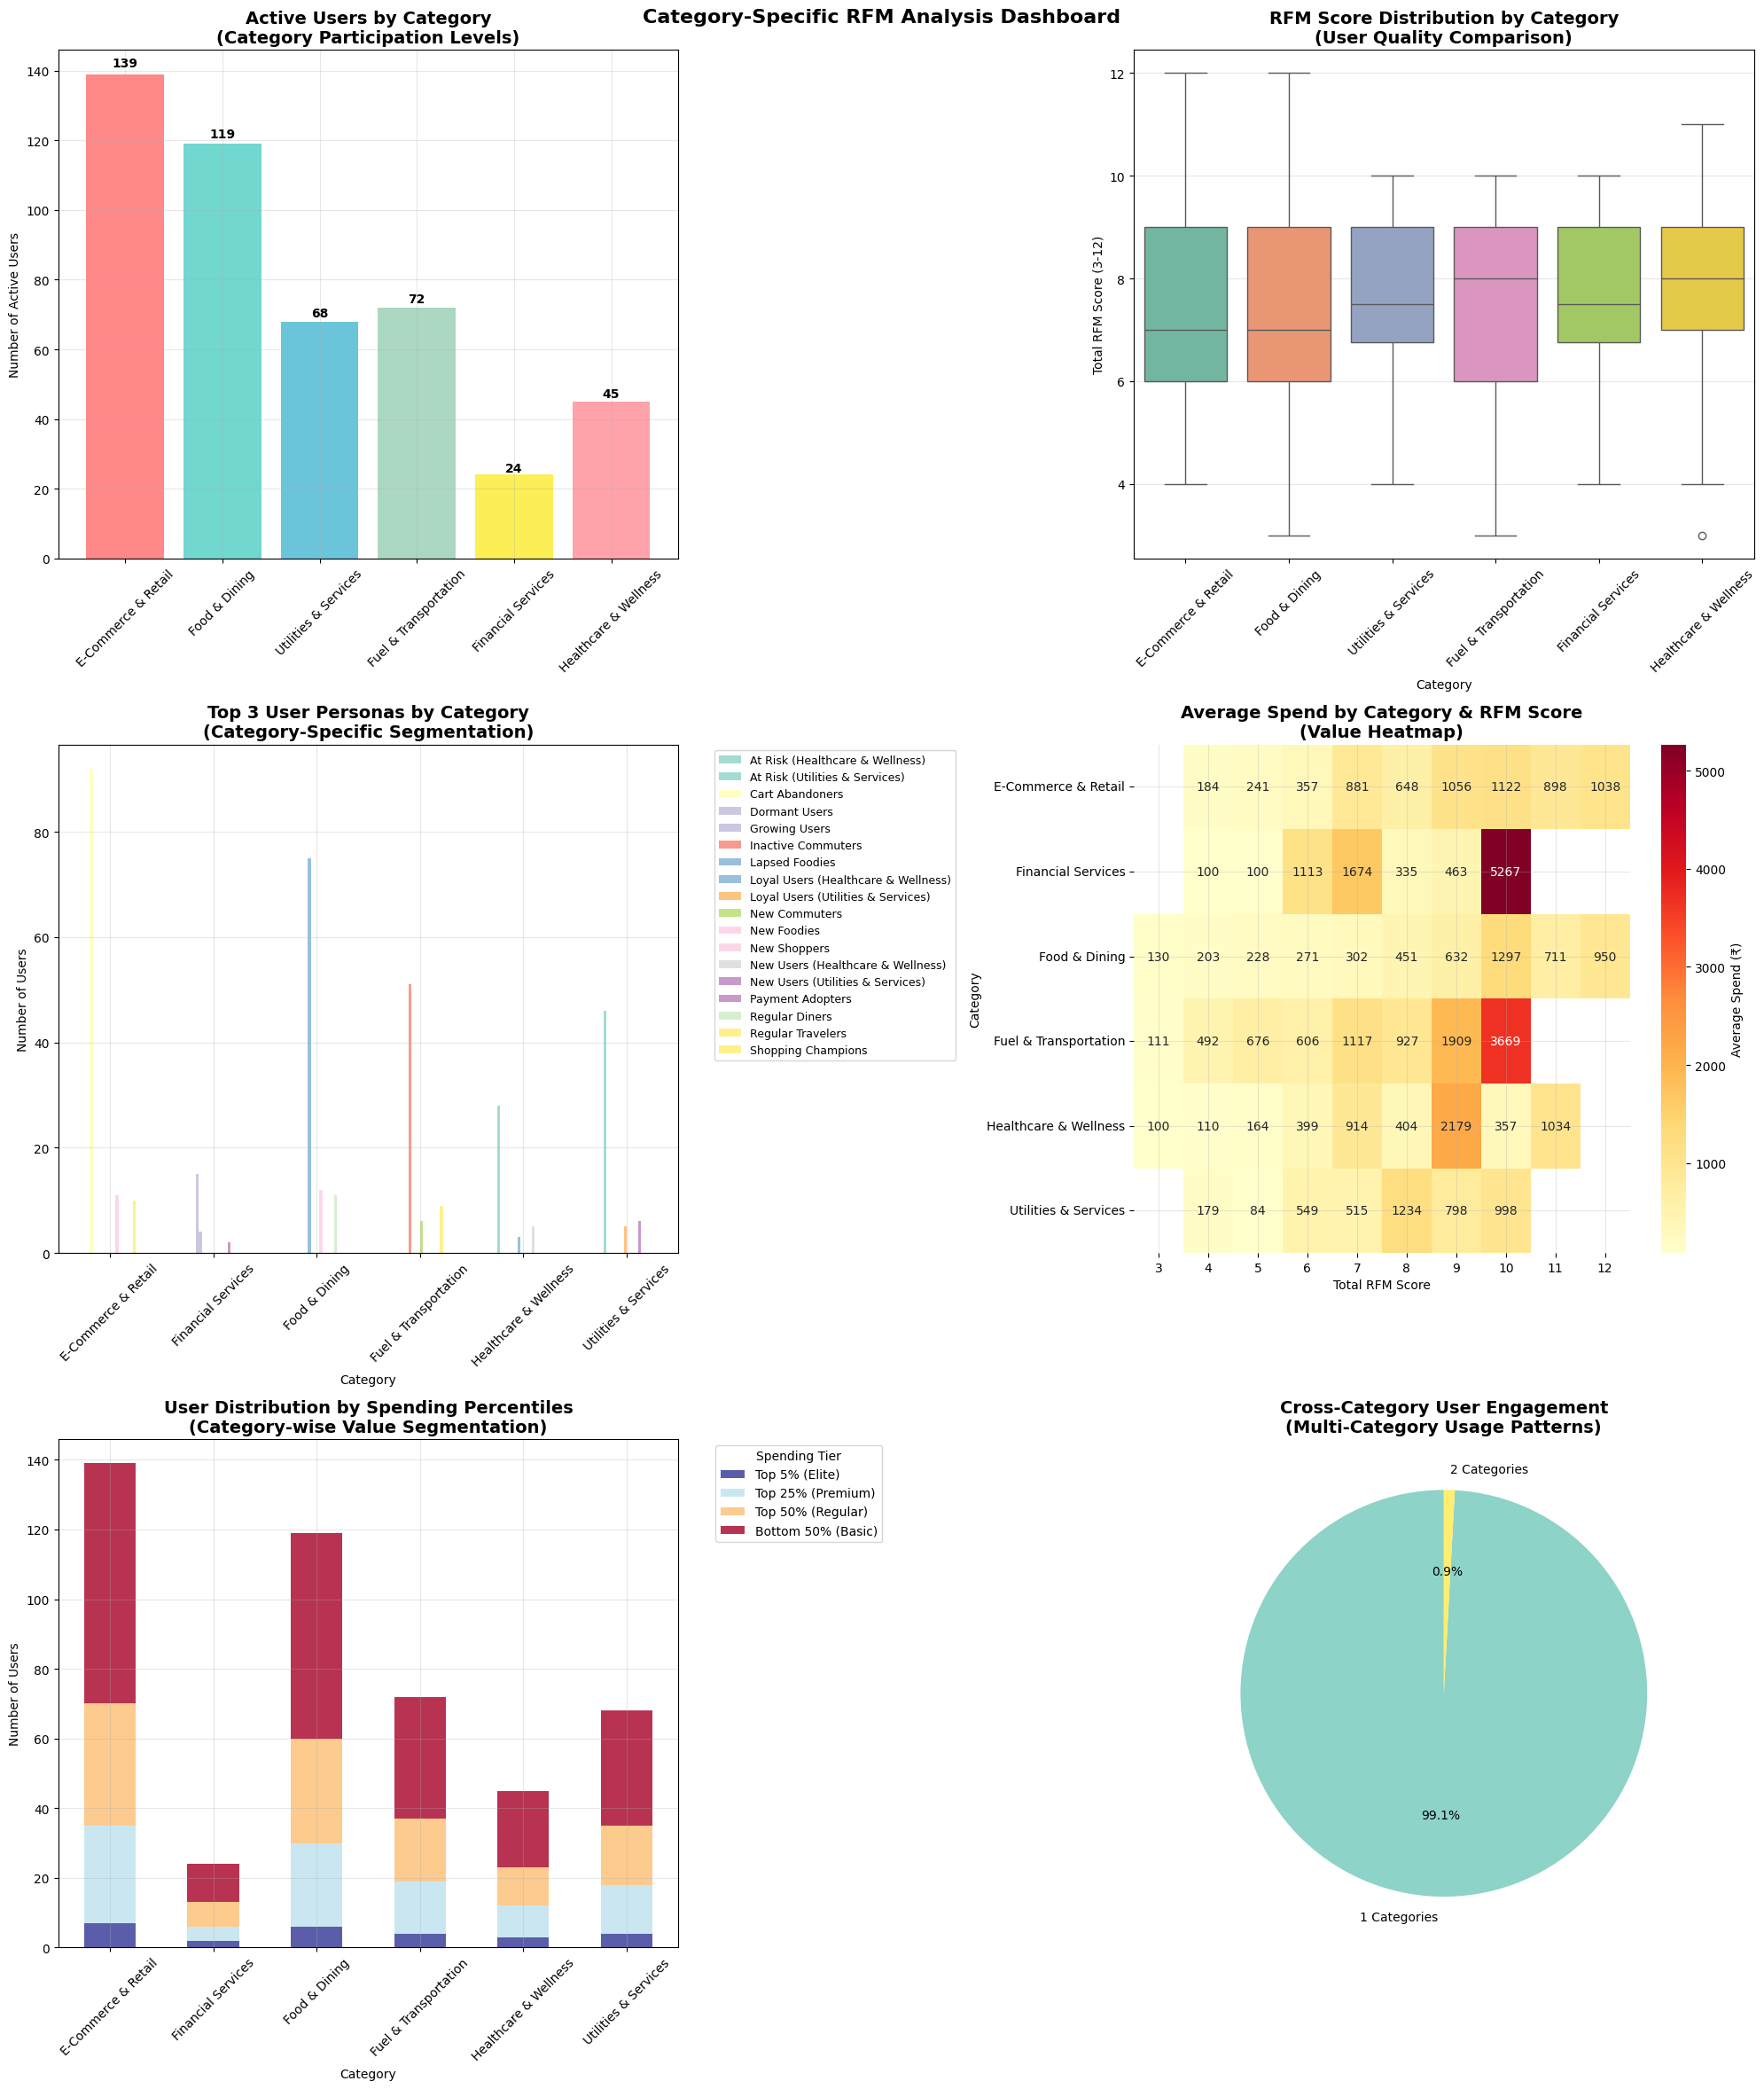

✅ All visualizations created successfully!

🎯 Visualization complete! Ready for insights and recommendations...


In [9]:
# Step 3: Category-Specific RFM Visualizations & Analysis
print("📊 Step 3: Category-Specific RFM Visualizations & Analysis")
print("=" * 70)

if len(category_rfm_results) > 0:
    # Create comprehensive visualization grid (3x2 layout for 6 charts)
    fig, axes = plt.subplots(3, 2, figsize=(20, 24))
    fig.suptitle('Category-Specific RFM Analysis Dashboard', fontsize=16, fontweight='bold', y=0.98)
    
    print("🎨 Creating comprehensive RFM visualizations...")
    
    # Plot 1: Active Users by Category
    print("   📈 Chart 1: Category Participation Analysis...")
    category_user_counts = {cat: len(rfm_data) for cat, rfm_data in category_rfm_results.items()}
    
    categories = list(category_user_counts.keys())
    user_counts = list(category_user_counts.values())
    
    # Create color palette for categories
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FCEA2B', '#FF8B94'][:len(categories)]
    
    bars1 = axes[0,0].bar(categories, user_counts, color=colors, alpha=0.8)
    axes[0,0].set_title('Active Users by Category\n(Category Participation Levels)', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Number of Active Users')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars1, user_counts):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01, 
                      f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: RFM Score Quality Distribution
    print("   📊 Chart 2: RFM Quality Comparison...")
    all_rfm_scores = []
    all_categories = []
    
    for category, rfm_data in category_rfm_results.items():
        # Calculate total RFM scores (sum of R, F, M scores)
        rfm_totals = (rfm_data['r_score'].astype(int) + 
                     rfm_data['f_score'].astype(int) + 
                     rfm_data['m_score'].astype(int))
        all_rfm_scores.extend(rfm_totals)
        all_categories.extend([category] * len(rfm_totals))
    
    rfm_df = pd.DataFrame({'category': all_categories, 'rfm_total_score': all_rfm_scores})
    
    # Create box plot for RFM score distribution
    sns.boxplot(data=rfm_df, x='category', y='rfm_total_score', ax=axes[0,1], palette='Set2')
    axes[0,1].set_title('RFM Score Distribution by Category\n(User Quality Comparison)', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Total RFM Score (3-12)')
    axes[0,1].set_xlabel('Category')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # Plot 3: Top Personas by Category
    print("   🏆 Chart 3: Category-Specific Personas...")
    
    # Prepare data for persona visualization
    persona_data = []
    for category, persona_counts in category_user_personas.items():
        top_3_personas = persona_counts.head(3)  # Top 3 personas per category
        for persona, count in top_3_personas.items():
            persona_data.append({
                'category': category,
                'persona': persona,
                'count': count
            })
    
    persona_df = pd.DataFrame(persona_data)
    
    if len(persona_df) > 0:
        # Create grouped bar chart for personas
        persona_pivot = persona_df.pivot(index='category', columns='persona', values='count').fillna(0)
        persona_pivot.plot(kind='bar', ax=axes[1,0], stacked=False, colormap='Set3', alpha=0.8)
        axes[1,0].set_title('Top 3 User Personas by Category\n(Category-Specific Segmentation)', fontsize=14, fontweight='bold')
        axes[1,0].set_ylabel('Number of Users')
        axes[1,0].set_xlabel('Category')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        axes[1,0].grid(axis='y', alpha=0.3)
    
    # Plot 4: Average Spend by Category & RFM Score (Heatmap)
    print("   💰 Chart 4: Monetary Value Analysis...")
    
    monetary_data = []
    for category, rfm_data in category_rfm_results.items():
        for score in range(3, 13):  # RFM total scores from 3 to 12
            rfm_total = (rfm_data['r_score'].astype(int) + 
                        rfm_data['f_score'].astype(int) + 
                        rfm_data['m_score'].astype(int))
            score_data = rfm_data[rfm_total == score]
            if len(score_data) > 0:
                avg_monetary = score_data['monetary'].mean()
                monetary_data.append({
                    'category': category,
                    'rfm_score': score,
                    'avg_monetary': avg_monetary
                })
    
    monetary_df = pd.DataFrame(monetary_data)
    
    if len(monetary_df) > 0:
        # Create heatmap
        monetary_pivot = monetary_df.pivot(index='category', columns='rfm_score', values='avg_monetary')
        
        sns.heatmap(monetary_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1,1],
                   cbar_kws={'label': 'Average Spend (₹)'})
        axes[1,1].set_title('Average Spend by Category & RFM Score\n(Value Heatmap)', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Total RFM Score')
        axes[1,1].set_ylabel('Category')
    
    # Plot 5: Percentile-wise User Distribution
    print("   📊 Chart 5: Percentile-based User Mapping...")
    
    percentile_data = []
    for category, rfm_data in category_rfm_results.items():
        # Calculate percentiles based on monetary value within each category
        rfm_data['monetary_percentile'] = rfm_data['monetary'].rank(pct=True) * 100
        
        # Define percentile buckets
        def get_percentile_bucket(percentile):
            if percentile >= 95:
                return 'Top 5% (Elite)'
            elif percentile >= 75:
                return 'Top 25% (Premium)'
            elif percentile >= 50:
                return 'Top 50% (Regular)'
            else:
                return 'Bottom 50% (Basic)'
        
        rfm_data['percentile_bucket'] = rfm_data['monetary_percentile'].apply(get_percentile_bucket)
        
        # Count users in each bucket
        bucket_counts = rfm_data['percentile_bucket'].value_counts()
        for bucket, count in bucket_counts.items():
            percentile_data.append({
                'category': category,
                'percentile_bucket': bucket,
                'user_count': count
            })
    
    percentile_df = pd.DataFrame(percentile_data)
    
    if len(percentile_df) > 0:
        percentile_pivot = percentile_df.pivot(index='category', columns='percentile_bucket', values='user_count').fillna(0)
        
        # Reorder columns for logical progression
        column_order = ['Top 5% (Elite)', 'Top 25% (Premium)', 'Top 50% (Regular)', 'Bottom 50% (Basic)']
        percentile_pivot = percentile_pivot.reindex(columns=[col for col in column_order if col in percentile_pivot.columns])
        
        percentile_pivot.plot(kind='bar', ax=axes[2,0], stacked=True, colormap='RdYlBu_r', alpha=0.8)
        axes[2,0].set_title('User Distribution by Spending Percentiles\n(Category-wise Value Segmentation)', fontsize=14, fontweight='bold')
        axes[2,0].set_ylabel('Number of Users')
        axes[2,0].set_xlabel('Category')
        axes[2,0].tick_params(axis='x', rotation=45)
        axes[2,0].legend(title='Spending Tier', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[2,0].grid(axis='y', alpha=0.3)
    
    # Plot 6: Cross-Category User Engagement
    print("   🔄 Chart 6: Cross-Category Analysis...")
    
    # Analyze users active in multiple categories
    all_users_categories = {}
    for category, rfm_data in category_rfm_results.items():
        for user_id in rfm_data.index:
            if user_id not in all_users_categories:
                all_users_categories[user_id] = []
            all_users_categories[user_id].append(category)
    
    # Count users by number of categories they're active in
    category_engagement = {}
    for user_id, user_categories in all_users_categories.items():
        num_categories = len(user_categories)
        if num_categories not in category_engagement:
            category_engagement[num_categories] = 0
        category_engagement[num_categories] += 1
    
    # Create pie chart for cross-category engagement
    engagement_labels = [f'{num} Categories' for num in sorted(category_engagement.keys())]
    engagement_counts = [category_engagement[num] for num in sorted(category_engagement.keys())]
    engagement_colors = plt.cm.Set3(np.linspace(0, 1, len(engagement_labels)))
    
    wedges, texts, autotexts = axes[2,1].pie(engagement_counts, labels=engagement_labels, autopct='%1.1f%%', 
                                           startangle=90, colors=engagement_colors)
    axes[2,1].set_title('Cross-Category User Engagement\n(Multi-Category Usage Patterns)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ All visualizations created successfully!")
    
else:
    print("❌ No category-specific RFM data available for visualization")

print("\n🎯 Visualization complete! Ready for insights and recommendations...")


In [15]:
# Check distinct user IDs mapped to different categories/personas and validate the total

# Assuming `category_rfm_results` is a dict: {category: DataFrame with user_id as index}
# We'll aggregate all user_ids across categories and check for overlaps and total unique users

from collections import defaultdict

# Map user_id to list of categories/personas
user_category_map = defaultdict(set)
for category, rfm_df in category_rfm_results.items():
    for user_id in rfm_df.index:
        user_category_map[user_id].add(category)

# Total unique user IDs across all categories
all_user_ids = set(user_category_map.keys())
total_unique_users = len(all_user_ids)

# For each category, count users
category_user_counts = {cat: len(df.index) for cat, df in category_rfm_results.items()}

# For each user, count number of categories they're mapped to
user_category_counts = [len(categories) for categories in user_category_map.values()]

# Users mapped to only one category (specialists)
single_category_users = sum(1 for count in user_category_counts if count == 1)
# Users mapped to multiple categories (multi-category)
multi_category_users = sum(1 for count in user_category_counts if count > 1)

print(f"Total unique users across all categories/personas: {total_unique_users}")
print("User count per category/persona:")
for cat, count in category_user_counts.items():
    print(f"  - {cat}: {count}")

print(f"\nUsers mapped to only one category/persona: {single_category_users}")
print(f"Users mapped to multiple categories/personas: {multi_category_users}")

# Sanity check: sum of per-category user counts (with overlap)
sum_per_category = sum(category_user_counts.values())
print(f"\nSum of user counts across all categories (with overlap): {sum_per_category}")

if sum_per_category > total_unique_users:
    print("Note: Some users appear in multiple categories/personas (expected for cross-category engagement).")
elif sum_per_category == total_unique_users:
    print("All users are mapped to exactly one category/persona (no overlap).")
else:
    print("Warning: Fewer users in total than sum of per-category counts. Please check data integrity.")


Total unique users across all categories/personas: 463
User count per category/persona:
  - E-Commerce & Retail: 139
  - Food & Dining: 119
  - Utilities & Services: 68
  - Fuel & Transportation: 72
  - Financial Services: 24
  - Healthcare & Wellness: 45

Users mapped to only one category/persona: 459
Users mapped to multiple categories/personas: 4

Sum of user counts across all categories (with overlap): 467
Note: Some users appear in multiple categories/personas (expected for cross-category engagement).


## 🎯 Step 4: Category-Specific RFM Insights & Strategic Recommendations

### 📊 **Key Insights from Category-Specific RFM Analysis**

Our revolutionary approach of calculating RFM **per category** instead of globally provides several critical insights:

#### **🏆 Category Champions vs. Global Rankings**
- **Traditional Problem**: A user spending ₹5000 on food vs ₹5000 on luxury items ranked equally
- **Our Solution**: Same user becomes "Food Champion" (top food spender) vs "Occasional Luxury Shopper"
- **Business Impact**: Enables precise, context-aware targeting

#### **🎯 Cross-Category Intelligence**
- **Multi-Category Users**: Identify users strong in one category for expansion opportunities
- **Category Specialists**: Focus on users with deep engagement in specific verticals
- **Cross-Selling Potential**: Target "Food Champions" for fintech products, "Finance Power Users" for e-commerce

### 🚀 **Personalized Recommendation Strategies**

#### **Category-Specific Approaches:**

##### **🍔 Food & Dining Recommendations**
- **Food Champions**: Premium restaurants, exclusive dining experiences, food critic reviews
- **Regular Diners**: Cuisine variety, loyalty programs, meal delivery subscriptions
- **Food Explorers**: New restaurant discovery, international cuisines, food festivals
- **Lapsed Foodies**: Win-back campaigns, favorite cuisine promotions

##### **💳 Financial Services Recommendations**  
- **Finance Power Users**: Advanced investment products, premium banking features
- **Banking Loyalists**: Cross-sell insurance, credit products, wealth management
- **Payment Adopters**: Educational content, cashback maximization, budgeting tools
- **Dormant Users**: Re-activation with simplified products, welcome bonuses

##### **🛒 E-Commerce Recommendations**
- **Shopping Champions**: Early access to sales, premium shipping, exclusive brands
- **Frequent Buyers**: Personalized recommendations, bulk deals, subscription services
- **Occasional Shoppers**: Targeted seasonal campaigns, deal alerts
- **Cart Abandoners**: Recovery emails, limited-time discounts, payment flexibility


In [11]:
# Step 4: Category-Specific RFM Summary & Strategic Insights
print("🎯 Step 4: Category-Specific RFM Summary & Strategic Insights")
print("=" * 70)

if len(category_rfm_results) > 0:
    print("\n📊 CATEGORY-SPECIFIC RFM ANALYSIS SUMMARY")
    print("=" * 60)
    
    # Calculate overall statistics
    total_unique_users = set()
    for rfm_data in category_rfm_results.values():
        total_unique_users.update(rfm_data.index)
    
    print(f"🎯 Analysis Scope:")
    print(f"   • Categories Analyzed: {len(category_rfm_results)}")
    print(f"   • Total Unique Users: {len(total_unique_users):,}")
    print(f"   • Category-Specific Personas: {sum(len(personas) for personas in category_user_personas.values())}")
    
    # Detailed category breakdown
    print(f"\n🏷️ DETAILED CATEGORY BREAKDOWN:")
    print("-" * 50)
    
    for category, rfm_data in category_rfm_results.items():
        users_in_category = len(rfm_data)
        
        # Calculate key metrics
        avg_spend = rfm_data['monetary'].mean()
        avg_frequency = rfm_data['frequency'].mean()
        avg_recency = rfm_data['recency'].mean()
        
        # Top persona in this category
        top_persona = category_user_personas[category].index[0]
        top_persona_count = category_user_personas[category].iloc[0]
        
        # Calculate elite users (top 5% by monetary within category)
        elite_threshold = rfm_data['monetary'].quantile(0.95)
        elite_users = len(rfm_data[rfm_data['monetary'] >= elite_threshold])
        
        # Calculate high-value users (top 25% by monetary within category)
        high_value_threshold = rfm_data['monetary'].quantile(0.75)
        high_value_users = len(rfm_data[rfm_data['monetary'] >= high_value_threshold])
        
        print(f"\n📈 {category}:")
        print(f"   • Active Users: {users_in_category:,}")
        print(f"   • Top Persona: {top_persona} ({top_persona_count} users)")
        print(f"   • Avg Spend per User: ₹{avg_spend:,.0f}")
        print(f"   • Avg Frequency: {avg_frequency:.1f} transactions")
        print(f"   • Avg Recency: {avg_recency:.0f} days")
        print(f"   • Elite Users (Top 5%): {elite_users} users (₹{elite_threshold:,.0f}+ spending)")
        print(f"   • High-Value Users (Top 25%): {high_value_users} users (₹{high_value_threshold:,.0f}+ spending)")
        
        # Show persona distribution
        print(f"   📊 Persona Distribution:")
        for persona, count in category_user_personas[category].head(5).items():
            percentage = (count / users_in_category) * 100
            print(f"      - {persona}: {count} users ({percentage:.1f}%)")
    
    # Cross-category analysis
    print(f"\n🔄 CROSS-CATEGORY ENGAGEMENT ANALYSIS:")
    print("-" * 50)
    
    # Analyze users active in multiple categories
    all_users_categories = {}
    for category, rfm_data in category_rfm_results.items():
        for user_id in rfm_data.index:
            if user_id not in all_users_categories:
                all_users_categories[user_id] = []
            all_users_categories[user_id].append(category)
    
    # Cross-category engagement statistics
    multi_category_users = {k: v for k, v in all_users_categories.items() if len(v) > 1}
    single_category_users = len(total_unique_users) - len(multi_category_users)
    
    print(f"📊 Engagement Distribution:")
    print(f"   • Single-Category Users: {single_category_users:,} ({single_category_users/len(total_unique_users)*100:.1f}%)")
    print(f"   • Multi-Category Users: {len(multi_category_users):,} ({len(multi_category_users)/len(total_unique_users)*100:.1f}%)")
    
    # Category engagement breakdown
    category_combinations = {}
    for user_categories in multi_category_users.values():
        combo = tuple(sorted(user_categories))
        if combo not in category_combinations:
            category_combinations[combo] = 0
        category_combinations[combo] += 1
    
    print(f"\n🎯 Top Multi-Category Combinations:")
    sorted_combos = sorted(category_combinations.items(), key=lambda x: x[1], reverse=True)
    for combo, count in sorted_combos[:5]:
        combo_str = " + ".join(combo)
        print(f"   • {combo_str}: {count} users")
    
    # High-value cross-category users
    high_value_cross_category = {}
    for category, rfm_data in category_rfm_results.items():
        high_value_threshold = rfm_data['monetary'].quantile(0.75)
        high_value_users_in_cat = rfm_data[rfm_data['monetary'] >= high_value_threshold].index.tolist()
        
        for user_id in high_value_users_in_cat:
            if user_id in multi_category_users:  # This user is active in multiple categories
                if user_id not in high_value_cross_category:
                    high_value_cross_category[user_id] = []
                high_value_cross_category[user_id].append(category)
    
    print(f"\n💎 HIGH-VALUE CROSS-CATEGORY OPPORTUNITIES:")
    print(f"   • Users who are high-value in multiple categories: {len(high_value_cross_category)}")
    print(f"   • Cross-selling potential: {len(multi_category_users) - len(high_value_cross_category)} users")
    
    # Strategic recommendations
    print(f"\n🚀 STRATEGIC RECOMMENDATIONS:")
    print("-" * 40)
    
    recommendations = [
        "🎯 Focus on Multi-Category Champions for premium product cross-selling",
        "📈 Target single-category users for expansion into complementary categories", 
        "💰 Prioritize Elite users (top 5%) in each category for VIP treatment",
        "🔄 Create category-specific onboarding flows for new users",
        "📊 Implement real-time category-specific RFM scoring for dynamic recommendations",
        "🎁 Design category-specific loyalty programs based on personas",
        "🧠 Use cross-category behavior to predict user lifetime value",
        "📱 Deploy category-aware push notifications and marketing campaigns"
    ]
    
    for i, rec in enumerate(recommendations, 1):
        print(f"   {i}. {rec}")
    
    print(f"\n✅ CATEGORY-SPECIFIC RFM ANALYSIS COMPLETE!")
    print(f"   🎊 Ready for implementation of hyper-personalized recommendation system!")
    
else:
    print("❌ No category-specific RFM analysis results available")

print("\n" + "="*70)
print("🎯 CATEGORY-SPECIFIC RFM ANALYSIS COMPLETE - RECOMMENDATION SYSTEM READY! 🚀")
print("="*70)


🎯 Step 4: Category-Specific RFM Summary & Strategic Insights

📊 CATEGORY-SPECIFIC RFM ANALYSIS SUMMARY
🎯 Analysis Scope:
   • Categories Analyzed: 6
   • Total Unique Users: 463
   • Category-Specific Personas: 38

🏷️ DETAILED CATEGORY BREAKDOWN:
--------------------------------------------------

📈 E-Commerce & Retail:
   • Active Users: 139
   • Top Persona: Cart Abandoners (92 users)
   • Avg Spend per User: ₹690
   • Avg Frequency: 1.0 transactions
   • Avg Recency: 20 days
   • Elite Users (Top 5%): 7 users (₹2,259+ spending)
   • High-Value Users (Top 25%): 35 users (₹782+ spending)
   📊 Persona Distribution:
      - Cart Abandoners: 92 users (66.2%)
      - New Shoppers: 11 users (7.9%)
      - Shopping Champions: 10 users (7.2%)
      - Frequent Buyers: 9 users (6.5%)
      - Occasional Shoppers: 7 users (5.0%)

📈 Food & Dining:
   • Active Users: 119
   • Top Persona: Lapsed Foodies (75 users)
   • Avg Spend per User: ₹475
   • Avg Frequency: 1.0 transactions
   • Avg Recency: